# Описание Датасета:
- **bodyType** - тип кузова
- **brand** - бренд авто
- **car_url** - ссылка объявление на сайте
- **color** - цвет авто
- **complectation_dict** - cловарь оборудования, входящего в комплектацию
- **description** - реклама салона, условия продавца
- **engineDisplacement** - объём двигателя, л.
- **enginePower** - мощность двигателя, л.с.
- **equipment_dict** - cловарь оборудования, входящего в комплектацию, частично дублирует complectation_dict
- **fuelType** - тип потребляемого топлива
- **image** - ссылка на фото авто на сайте
- **mileage** - пробег, км
- **modelDate** - дата начала выпуска данной модели
- **model_info** - cловарь с данными о модели
- **model_name** - название модели
- **name** - данные об объёме двигателя, мощности авто и типе коробки передач
- **numberOfDoors** - количество дверей
- **parsing_unixtime** - время парсинга
- **priceCurrency** - валюта, в которой указана стоимость авто на сайте
- **productionDate** - дата производства
- **sell_id** - ID номер в базе
- **super_gen** - cловарь с техническими характеристиками
- **vehicleConfiguration** - признак дублирующий (bodyType, engineDisplacement и vehicleTransmission)
- **vehicleTransmission** - тип коробки передач
- **vendor** - регион первичной продажи/производства авто
- **Владельцы** - сведения о количестве предыдущих владельцев
- **Владение** - время последнего владения
- **ПТС** - вид паспорта транспортного средства
- **Привод** - тип привода
- **Руль** - положение руля
- **Состояние** - состояние, в котором находится продаваемое авто
- **Таможня** - сведения о таможне

# Import

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

import re
import sys
import json
from collections import Counter

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error


import warnings
warnings.filterwarnings('ignore')

import pandas_profiling

pd.set_option('display.max_columns', 200)

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.20.3


In [3]:
RANDOM_SEED = 42
!pip3 freeze > requirements.txt

# Functions

In [4]:
def IQR_outlier(data, column, verbose=True):
    '''
    Функция для отображения границ межквартильного размаха
    '''
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    count_outliers = len(data[data[column] > high])+len(data[data[column] < low])
    if verbose:
        print('Для признака', column, ':')
        print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
              "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return print('Выбросов, согласно IQR: {} | {:2.2%}'.format(count_outliers, count_outliers
                                                               /len(data)))

In [5]:
def replacement(set_X, data, col):
    """Функция замены значений в столбце с помощью словаря"""

    for key in set_X:
        list_change = list(data[data[col].str.contains(key, na=False)][col].unique())
        data[col] = data[col].apply(lambda x: set_X[key] if x in list_change else x)

In [6]:
def replacement_1(set_X, data, col):
    """Функция замены значений в столбце с помощью словаря"""

    for key in set_X:
        data[col] = data[col].apply(lambda x: set_X[key] if x==key else x)

In [7]:
def dict_to_list(value):
    '''Преобразует complectation_dict в список'''
    complectation = []
    try:
        complectation_list = re.findall(r'\[.*?\]', str(value))[0][1:-1].split(',')
        for complect in complectation_list:
            complectation.append(complect[1:-1])
        return complectation
    except IndexError:
        return None

In [8]:
def engine_displacement(value):
    """Функция для преобразования признака engineDisplacement"""

    if value == None:
        return value
    else:
        value = re.findall(r'\d\.\d', str(value))
        if value == list():
            value = 0.0
        else:
            value = float(value[0])
    return value

In [9]:
def enginePower(value):
    """Функция для преобразования признака enginePower"""

    if value == 'None':
        return None
    else:
        value = re.findall(r'\d+', str(value))
        if value == list():
            return None
        else:
            value = int(value[0])
    return value

In [10]:
def enginePower_nan(value):
    """Функция для заполнения пропусков в признаке enginePower"""

    if value == None:
        return value
    else:
        value = int(re.findall(r'\(.*л.с.\)', value)[0][1:-6])
        return value

In [11]:
def equipment_dict_to_list(value):
    '''Преобразует equipment_dict в список'''
    equipment = []

    equipment_list = re.findall(r'".*?"', str(value))
    for complect in equipment_list:
        equipment.append(complect[1:-1])
    return equipment

In [12]:
def complectation_new(row):
    '''Создание нового признака complectation_new'''
    if not row.complectation_dict:
        row.complectation_dict = set()

    if not row.equipment_dict:
        row.equipment_dict = set()

    row['complectation_new'] = set(row.complectation_dict).union(set(row.equipment_dict))
    if not row['complectation_new']:
        row['complectation_new'] = 'not known'

    return row

In [13]:
def model_date(value):
    if value == "None":
        return None
    elif value == "NaN":
        return None
    else:
        try:
            return int(value)
        except:
            print(f'[ERROR] {value} type: {type(value)}')
            return None

In [14]:
def usd(row):
    '''Создание нового признака USD'''
    if row.parsing_unixtime == '2020-09-09':
        row['usd'] = 1 / 75.9645
    elif row.parsing_unixtime == '2020-10-21':
        row['usd'] = 1 / 77.7780
    elif row.parsing_unixtime == '2022-02-21':
        row['usd'] = 1 / 75.7619
    elif row.parsing_unixtime == '2020-10-20':
        row['usd'] = 1 / 77.9241
    elif row.parsing_unixtime == '2022-02-22':
        row['usd'] = 1 / 76.7671
    elif row.parsing_unixtime == '2020-10-19':
        row['usd'] = 1 / 77.9644
    elif row.parsing_unixtime == '2022-02-23':
        row['usd'] = 1 / 80.4194
    elif row.parsing_unixtime == '2022-02-24':
        row['usd'] = 1 / 80.4194
    elif row.parsing_unixtime == '2020-10-25':
        row['usd'] = 1 / 76.4667
    elif row.parsing_unixtime == '2020-10-24':
        row['usd'] = 1 / 76.4667
    elif row.parsing_unixtime == '2020-10-26':
        row['usd'] = 1 / 76.4667
    return row

In [15]:
def production_date(value):
    if value == "None":
        return None
    elif value == "NaN":
        return None
    else:
        try:
            return int(value)
        except:
            print(f'[ERROR] {value} type: {type(value)}')
            return None

In [16]:
def model_date(value):
    if value == "None":
        return None
    elif value == "NaN":
        return None
    else:
        try:
            return int(value)
        except:
            print(f'[ERROR] {value} type: {type(value)}')
            return None

In [17]:
def vendor(row):
    '''Преобразует vendor в список'''
    if row.brand.lower() == 'skoda':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'audi':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'honda':
        row.vendor = 'JAPANESE'
    elif row.brand.lower() == 'volvo':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'volvo':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'bmw':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'nissan':
        row.vendor = 'JAPANESE'
    elif row.brand.lower() == 'infiniti':
        row.vendor = 'JAPANESE'
    elif row.brand.lower() == 'mercedes':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'toyota':
        row.vendor = 'JAPANESE'
    elif row.brand.lower() == 'lexus':
        row.vendor = 'JAPANESE'
    elif row.brand.lower() == 'volkswagen':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'cadillac':
        row.vendor = 'USA'
    elif row.brand.lower() == 'chery':
        row.vendor = 'CHINESE'
    elif row.brand.lower() == 'chevrolet':
        row.vendor = 'USA'
    elif row.brand.lower() == 'chrysler':
        row.vendor = 'USA'
    elif row.brand.lower() == 'citroen':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'daewoo':
        row.vendor = 'KOREAN'
    elif row.brand.lower() == 'dodge':
        row.vendor = 'USA'
    elif row.brand.lower() == 'ford':
        row.vendor = 'USA'
    elif row.brand.lower() == 'geely':
        row.vendor = 'CHINESE'
    elif row.brand.lower() == 'hyundai':
        row.vendor = 'KOREAN'
    elif row.brand.lower() == 'jaguar':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'jaguar':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'jeep':
        row.vendor = 'USA'
    elif row.brand.lower() == 'kia':
        row.vendor = 'KOREAN'
    elif row.brand.lower() == 'mazda':
        row.vendor = 'JAPANESE'
    elif row.brand.lower() == 'mini':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'opel':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'peugeot':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'porsche':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'renault':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'subaru':
        row.vendor = 'JAPANESE'
    elif row.brand.lower() == 'suzuki':
        row.vendor = 'JAPANESE'
    elif row.brand.lower() == 'great_wall':
        row.vendor = 'CHINESE'
    elif row.brand.lower() == 'land_rover':
        row.vendor = 'EUROPEAN'
    elif row.brand.lower() == 'ssang_yong':
        row.vendor = 'KOREAN'
    elif row.brand.lower() == 'mitsubishi':
        row.vendor = 'JAPANESE'
    else:
        row.vendor = 'OTHER'

    return row

In [18]:
def heatmap(data, columns, method):
    corr = data[columns].corr(method=method)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(10, 10))
        ax = sns.heatmap(corr, mask=mask, annot=True, square=True, vmin=0, vmax=1)

In [19]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Data

In [20]:
df_sample_submission = pd.read_csv('sample_submission.csv')
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('all_auto_ru_09_09_2020.csv')

with open('1.json', 'r', encoding="utf-8") as file:
    data = json.load(file)

df_0 = pd.json_normalize(data)

with open('data_Audi.json', 'r', encoding="utf-8") as file:
    data = json.load(file)

df_Audi = pd.json_normalize(data)

with open('data_BMW.json', 'r', encoding="utf-8") as file:
    data = json.load(file)

df_BMW = pd.json_normalize(data)

with open('data_Chery.json', 'r', encoding="utf-8") as file:
    data = json.load(file)

df_Chery = pd.json_normalize(data)

In [21]:
print('df_sample_submission:')
display(df_sample_submission.head(10))

df_sample_submission:


sell_id  price
0  1100575026      0
1  1100549428      0
2  1100658222      0
3  1100937408      0
4  1101037972      0
5  1100912634      0
6  1101228730      0
7  1100165896      0
8  1100768262      0
9  1101218501      0

In [22]:
print("Размер датасета df_sample_submission:", df_sample_submission.shape)
print()
df_sample_submission.info()

Размер датасета df_sample_submission: (34686, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sell_id  34686 non-null  int64
 1   price    34686 non-null  int64
dtypes: int64(2)
memory usage: 542.1 KB


In [23]:
print('df_test:')
display(df_test.head(10))

df_test:


bodyType  brand  \
0            лифтбек  SKODA   
1            лифтбек  SKODA   
2            лифтбек  SKODA   
3            лифтбек  SKODA   
4            лифтбек  SKODA   
5            лифтбек  SKODA   
6  внедорожник 5 дв.  SKODA   
7            лифтбек  SKODA   
8  внедорожник 5 дв.  SKODA   
9  внедорожник 5 дв.  SKODA   

                                             car_url       color  \
0  https://auto.ru/cars/used/sale/skoda/octavia/1...       синий   
1  https://auto.ru/cars/used/sale/skoda/octavia/1...      чёрный   
2  https://auto.ru/cars/used/sale/skoda/superb/11...       серый   
3  https://auto.ru/cars/used/sale/skoda/octavia/1...  коричневый   
4  https://auto.ru/cars/used/sale/skoda/octavia/1...       белый   
5  https://auto.ru/cars/used/sale/skoda/octavia_r...       серый   
6  https://auto.ru/cars/used/sale/skoda/yeti/1101...   пурпурный   
7  https://auto.ru/cars/used/sale/skoda/octavia/1...       белый   
8  https://auto.ru/cars/used/sale/skoda/kodiaq/11...     бежевый   
9  https://auto.ru/cars/used/sale/skoda/yeti/1101...       белый   

                                  complectation_dict  \
0                                                NaN   
1                                                NaN   
2  {"id":"20026336","name":"Ambition","available_...   
3  {"id":"20803582","name":"Ambition","available_...   
4                                                NaN   
5  {"id":"5011515","name":"RS","available_options...   
6  {"id":"20069264","name":"Elegance","available_...   
7                                                NaN   
8                                                NaN   
9                                                NaN   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6 LTR   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8 LTR   
5  Продаю свой автомобиль! Автомобиль полностью и...            2.0 LTR   
6  - выгода 60 000 рублей при покупке авто в Trad...            1.8 LTR   
7  ЛОТ: 01214644\nАвтопрага Юг\n\nВы можете получ...            1.6 LTR   
8  ЛОТ: 01217938\nАвтопрага Север\nДанный автомоб...            1.4 LTR   
9  ЛОТ: 01222831\nАвтопрага Север\n\nВы можете по...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
3     110 N12  {"cruise-control":true,"roller-blind-for-rear-...   бензин   
4     152 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
5     200 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
6     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
7     102 N12  {"asr":true,"tinted-glass":true,"airbag-driver...   бензин   
8     150 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
9     152 N12  {"asr":true,"tinted-glass":true,"esp":true,"ai...   бензин   

                                               image  mileage  modelDate  \
0  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    74000       2013   
1  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    60563       2017   
2  https://avatars.mds.yandex.net/get-autoru-vos/...    88000       2013   
3  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    95000       2013   
4  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    58536       2008   
5  https://avatars.mds.yandex.net/get-autoru-vos/...   172000       2008   
6  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...   107000       2009   
7  https://autoru.nayd

In [24]:
print("Размер датасета df_test:", df_test.shape)
print()
df_test.info()

Размер датасета df_test: (34686, 32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15

In [25]:
print('df_train:')
display(df_train.head(10))

df_train:


bodyType brand   color fuelType  modelDate                   name  \
0            Седан  AUDI  040001   бензин     1990.0  2.8 MT (174 л.с.) 4WD   
1            Седан  AUDI  EE1D19   бензин     1982.0       1.8 MT (90 л.с.)   
2  Универсал 5 дв.  AUDI  0000CC   бензин     1988.0  2.3 MT (136 л.с.) 4WD   
3            Седан  AUDI  CACECB   бензин     1988.0       1.8 MT (90 л.с.)   
4            Седан  AUDI  040001   бензин     1990.0      2.0 MT (101 л.с.)   
5            Седан  AUDI  007F00   бензин     1990.0      2.8 MT (174 л.с.)   
6            Седан  AUDI  007F00   бензин     1990.0      2.3 MT (133 л.с.)   
7  Универсал 5 дв.  AUDI  FAFBFB   бензин     1990.0      2.3 MT (133 л.с.)   
8            Седан  AUDI  040001   бензин     1990.0  2.8 MT (174 л.с.) 4WD   
9            Седан  AUDI  040001   бензин     1990.0      2.3 MT (133 л.с.)   

   numberOfDoors  productionDate          vehicleConfiguration  \
0            4.0            1991          SEDAN MECHANICAL 2.8   
1            4.0            1986          SEDAN MECHANICAL 1.8   
2            5.0            1989  WAGON_5_DOORS MECHANICAL 2.3   
3            4.0            1989          SEDAN MECHANICAL 1.8   
4            4.0            1991          SEDAN MECHANICAL 2.0   
5            4.0            1993          SEDAN MECHANICAL 2.8   
6            4.0            1992          SEDAN MECHANICAL 2.3   
7            5.0            1991  WAGON_5_DOORS MECHANICAL 2.3   
8            4.0            1992          SEDAN MECHANICAL 2.8   
9            4.0            1992          SEDAN MECHANICAL 2.3   

  vehicleTransmission engineDisplacement  enginePower  \
0          MECHANICAL                2.8        174.0   
1          MECHANICAL                1.8         90.0   
2          MECHANICAL                2.3        136.0   
3          MECHANICAL                1.8         90.0   
4          MECHANICAL                2.0        101.0   
5          MECHANICAL                2.8        174.0   
6          MECHANICAL                2.3        133.0   
7          MECHANICAL                2.3        133.0   
8          MECHANICAL                2.8        174.0   
9          MECHANICAL                2.3        133.0   

                                         description  mileage Комплектация  \
0   Машина  в приличном состоянии ,не гнилая не р...   350000  {'id': '0'}   
1  Машина в оригинале не гнилая все вопросы по те...   173424  {'id': '0'}   
2  ПТС Оригинал!\nПолный комплект ключей!\nПо рез...   230000  {'id': '0'}   
3                                                NaN   240000  {'id': '0'}   
4  Машина не гнилая, дыр нет, днище целое, даже в...   300000  {'id': '0'}   
5  Хорошая комплектация: климат, эл. стекла, эл. ...   200000  {'id': '0'}   
6  Машина на ходу! По кузову требуется приложить ...   323000  {'id': '0'}   
7  Продаётся Avant. \nСостояние не плохое.\nСалон...   300000  {'id': '0'}   
8  Оформлена на меня, я владелец, по документам в...   371200  {'id': '0'}   
9  Продаю свою Ауди цена 110 без с минимальным то...   456000  {'id': '0'}   

     Привод  Руль  Состояние  Владельцы        ПТС  Таможня  \
0    полный  LEFT        NaN        3.0   ORIGINAL     True   
1  передний  LEFT        NaN        3.0   ORIGINAL     True   
2    полный  LEFT        NaN        3.0   ORIGINAL     True   
3  передний  LEFT        NaN        3.0   ORIGINAL     True   
4  передний  LEFT        NaN        3.0  DUPLICATE     True   
5  передний  LEFT        NaN        3.0   ORIGINAL     True   
6  передний  LEFT        NaN        1.0  DUPLICATE     True   
7  передний  LEFT        NaN        3.0   ORIGINAL     True   
8    полный  LEFT        NaN        3.0  DUPLICATE     True   
9  передний  LEFT        NaN        3.0  DUPLICATE     True   

                      Владение     price            start_date  hidden model  
0                          NaN  200000.0  2019-10-03T08:09:11Z     NaN   100  
1                          NaN   60000.0  2020-09-06T06:49:40Z     NaN   1

In [26]:
print("Размер датасета df_train:", df_train.shape)
print()
df_train.info()

Размер датасета df_train: (89378, 26)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non

In [27]:
print('df_0:')
display(df_0.head(10))

df_0:


bodyType brand                                            car_url  \
0    универсал 5 дв.  audi  https://auto.ru/cars/used/sale/audi/a4/1106680...   
1  внедорожник 5 дв.  audi  https://auto.ru/cars/used/sale/audi/q7/1106340...   
2              седан  audi  https://auto.ru/cars/used/sale/audi/a6/1106523...   
3              седан  audi  https://auto.ru/cars/used/sale/audi/a4/1106546...   
4            лифтбек  audi  https://auto.ru/cars/used/sale/audi/a7/1114852...   
5               купе  audi  https://auto.ru/cars/used/sale/audi/a5/1114831...   
6              седан  audi  https://auto.ru/cars/used/sale/audi/a4/1106045...   
7      хэтчбек 5 дв.  audi  https://auto.ru/cars/used/sale/audi/a3/1114615...   
8              седан  audi  https://auto.ru/cars/used/sale/audi/a4/1106586...   
9  внедорожник 5 дв.  audi  https://auto.ru/cars/used/sale/audi/q8/1114844...   

         color                                 complectation_dict  \
0   коричневый  ["equipmentGroups":[{"name":"Безопасность","va...   
1        белый                                                 []   
2       чёрный  ["equipmentGroups":[{"name":"Безопасность","va...   
3   коричневый  ["equipmentGroups":[{"name":"Безопасность","va...   
4        белый                                                 []   
5       чёрный  ["equipmentGroups":[{"name":"Безопасность","va...   
6        синий  ["equipmentGroups":[{"name":"Безопасность","va...   
7        серый  ["equipmentGroups":[{"name":"Безопасность","va...   
8        серый  ["equipmentGroups":[{"name":"Безопасность","va...   
9  серебристый  ["equipmentGroups":[{"name":"Безопасность","va...   

                                         description  engineDisplacement  \
0  Официальный дилер  Рено\n\nПокупался у официал...  1.8 л / 170 л.с. /   
1  Автомобиль в отличном состоянии,куплен новым у...  3.0 л / 249 л.с. /   
2  ∙    2 ключа∙    Комплектация ,бизнес ( комбин...  2.0 л / 249 л.с. /   
3  Преимущества данного авто:\n— 1 собственник— П...  1.8 л / 170 л.с. /   
4  Авто в отличном состоянии,до налоговый,не прок...  2.8 л / 204 л.с. /   
5  АВТОРАССРОЧКА НА АВТОМОБИЛИ С ПРОБЕГОМ 0%!*\nП...  2.0 л / 211 л.с. /   
6  АВТОРАССРОЧКА НА АВТОМОБИЛИ С ПРОБЕГОМ 0%!*\nП...  2.0 л / 249 л.с. /   
7  ЛОТ: 01313658\nЛокация №15\nФаворит Моторс Вос...  1.6 л / 102 л.с. /   
8  ∙    1 владелец∙    Оригинал ПТС∙    Автомобил...  1.8 л / 170 л.с. /   
9  💸Выгода до 100 000 рублей при покупке в кредит...  3.0 л / 249 л.с. /   

  enginePower                                     equipment_dict fuelType  \
0         170  ["equipment":{"tinted-glass":true,"esp":true,"...   Бензин   
1         249                                   ["equipment":{}]   Дизель   
2         249  ["equipment":{"cruise-control":true,"tinted-gl...   Бензин   
3         170  ["equipment":{"asr":true,"esp":true,"usb":true...   Бензин   
4         204                                   ["equipment":{}]   Бензин   
5         211  ["equipment":{"cruise-control":true,"electro-w...   Бензин   
6         249  ["equipment":{"cruise-control":true,"asr":true...   Бензин   
7         102  ["equipment":{"tinted-glass":true,"airbag-driv...   Бензин   
8         170  ["equipment":{"cruise-control":true,"esp":true...   Бензин   
9         249  ["equipment":{"cruise-control":true,"asr":true...   Дизель   

                                               image mileage modelDate  \
0  [https://autoru.naydex.net/uE2Ga6355/d37e97cwn...  113000      2012   
1  [https://avatars.mds.yandex.net/get-autoru-vos...  110000      2019   
2  [https://avatars.mds.yandex.net/get-autoru-vos...   43908      2018   
3  [https://avatars.mds.yandex.net/get-autoru-vos...   99000      2013   
4  [https://avatars.mds.yandex.net/get-autoru-vos...  131000      2011   
5  [https://autoru.naydex.net/uE2Ga6355/d37e97cwn...  130388      2012   
6  [https://avatars.mds.yandex.net/get-autoru-vos...   32360      2017   
7  [https://avatars.mds.yandex.net/get-autoru-vos...  182526      2008   
8  [https

In [28]:
print("Размер датасета df_0:", df_0.shape)
print()
df_0.info()

Размер датасета df_0: (14982, 33)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14982 entries, 0 to 14981
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   bodyType                   14982 non-null  object
 1   brand                      14982 non-null  object
 2   car_url                    14982 non-null  object
 3   color                      14982 non-null  object
 4   complectation_dict         14982 non-null  object
 5   description                14691 non-null  object
 6   engineDisplacement         14904 non-null  object
 7   enginePower                14982 non-null  object
 8   equipment_dict             14982 non-null  object
 9   fuelType                   14904 non-null  object
 10  image                      14981 non-null  object
 11  mileage                    14982 non-null  object
 12  modelDate                  14982 non-null  object
 13  model_info                

In [29]:
print('df_Audi:')
display(df_Audi.head(10))

df_Audi:


bodyType brand                                            car_url  \
0              седан  audi  https://auto.ru/cars/used/sale/audi/a6/1106255...   
1              седан  audi  https://auto.ru/cars/used/sale/audi/a3/1106260...   
2    универсал 5 дв.  audi  https://auto.ru/cars/used/sale/audi/a4_allroad...   
3              седан  audi  https://auto.ru/cars/used/sale/audi/a4/1114681...   
4  внедорожник 5 дв.  audi  https://auto.ru/cars/used/sale/audi/q7/1105851...   
5      хэтчбек 5 дв.  audi  https://auto.ru/cars/used/sale/audi/a3/1114880...   
6               купе  audi  https://auto.ru/cars/used/sale/audi/a5/1114767...   
7              седан  audi  https://auto.ru/cars/used/sale/audi/a6/1114651...   
8              седан  audi  https://auto.ru/cars/used/sale/audi/a4/1114853...   
9      хэтчбек 5 дв.  audi  https://auto.ru/cars/used/sale/audi/a1/1114643...   

         color                                 complectation_dict  \
0       чёрный  ["equipmentGroups":[{"name":"Безопасность","va...   
1        синий  ["equipmentGroups":[{"name":"Безопасность","va...   
2       чёрный  ["equipmentGroups":[{"name":"Безопасность","va...   
3        серый  ["equipmentGroups":[{"name":"Безопасность","va...   
4       чёрный  ["equipmentGroups":[{"name":"Безопасность","va...   
5        белый  ["equipmentGroups":[{"name":"Безопасность","va...   
6        серый  ["equipmentGroups":[{"name":"Безопасность","va...   
7  серебристый  ["equipmentGroups":[{"name":"Безопасность","va...   
8  серебристый  ["equipmentGroups":[{"name":"Безопасность","va...   
9        белый  ["equipmentGroups":[{"name":"Безопасность","va...   

                                         description  engineDisplacement  \
0  АВТОРАССРОЧКА НА АВТОМОБИЛИ С ПРОБЕГОМ 0%!*\nП...  2.0 л / 249 л.с. /   
1  Автомобиль продаётся официальным дилером BMW -...  1.4 л / 150 л.с. /   
2  Продаю отличный автомобиль, обслуживался на ди...  2.0 л / 225 л.с. /   
3  Последнее ТО 03.02.2022Сделано:1)Пыльники пере...  2.0 л / 200 л.с. /   
4  Просьба перекупщиков и автосалоны не беспокоит...  3.0 л / 249 л.с. /   
5  АВТОРАССРОЧКА НА АВТОМОБИЛИ С ПРОБЕГОМ 0%!*\nП...  1.4 л / 122 л.с. /   
6  + Один собственник за весь период эксплуатации...  2.0 л / 249 л.с. /   
7  Автомобиль в отличном состоянии, использовался...  2.0 л / 190 л.с. /   
8  АВТОРАССРОЧКА НА АВТОМОБИЛИ С ПРОБЕГОМ 0%!*\nП...  1.8 л / 170 л.с. /   
9  АВТОРАССРОЧКА НА АВТОМОБИЛИ С ПРОБЕГОМ 0%!*\nП...  1.4 л / 122 л.с. /   

  enginePower                                     equipment_dict fuelType  \
0         249  ["equipment":{"cruise-control":true,"asr":true...   Бензин   
1         150  ["equipment":{"asr":true,"esp":true,"usb":true...   Бензин   
2         225  ["equipment":{"cruise-control":true,"tinted-gl...   Бензин   
3         200  ["equipment":{"esp":true,"sport-seats":true,"l...   Бензин   
4         249  ["equipment":{"cruise-control":true,"asr":true...   Дизель   
5         122  ["equipment":{"cruise-control":true,"asr":true...   Бензин   
6         249  ["equipment":{"cruise-control":true,"asr":true...   Бензин   
7         190  ["equipment":{"esp":true,"multi-wheel":true,"s...   Дизель   
8         170  ["equipment":{"cruise-control":true,"asr":true...   Бензин   
9         122  ["equipment":{"cruise-control":true,"asr":true...   Бензин   

                                               image mileage modelDate  \
0  [https://avatars.mds.yandex.net/get-autoru-vos...  106220      2018   
1  [https://avatars.mds.yandex.net/get-autoru-vos...    5859      2021   
2  [https://avatars.mds.yandex.net/get-autoru-vos...  170000      2013   
3  [https://avatars.mds.yandex.net/get-autoru-vos...  205000      2007   
4  [https://avatars.mds.yandex.net/get-autoru-vos...   24300      2021   
5  [https://avatars.mds.yandex.net/get-autoru-vos...  110126      2013   
6  [https://avatars.mds.yandex.net/get-autoru-vos...   48100      2016   
7  [https://avatars.mds.yandex.net/get-autoru-vos...   42372      2017   
8  [https

In [30]:
print("Размер датасета df_Audi:", df_Audi.shape)
print()
df_Audi.info()

Размер датасета df_Audi: (1900, 33)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   bodyType                   1856 non-null   object
 1   brand                      1900 non-null   object
 2   car_url                    1900 non-null   object
 3   color                      1856 non-null   object
 4   complectation_dict         1856 non-null   object
 5   description                1816 non-null   object
 6   engineDisplacement         1825 non-null   object
 7   enginePower                1856 non-null   object
 8   equipment_dict             1856 non-null   object
 9   fuelType                   1825 non-null   object
 10  image                      1856 non-null   object
 11  mileage                    1856 non-null   object
 12  modelDate                  1856 non-null   object
 13  model_info                

In [31]:
print('df_BMW:')
display(df_BMW.head(10))

df_BMW:


bodyType brand                                            car_url  \
0  внедорожник 5 дв.   bmw  https://auto.ru/cars/used/sale/bmw/x7/11063450...   
1               None   bmw  https://auto.ru/cars/used/sale/bmw/x5_m/110546...   
2              седан   bmw  https://auto.ru/cars/used/sale/bmw/3er/1106486...   
3      хэтчбек 5 дв.   bmw  https://auto.ru/cars/used/sale/bmw/1er/1114591...   
4               купе   bmw  https://auto.ru/cars/used/sale/bmw/m3/11066952...   
5              седан   bmw  https://auto.ru/cars/used/sale/bmw/7er/1114688...   
6              седан   bmw  https://auto.ru/cars/used/sale/bmw/5er/1114770...   
7  внедорожник 5 дв.   bmw  https://auto.ru/cars/used/sale/bmw/x3/11147068...   
8      хэтчбек 5 дв.   bmw  https://auto.ru/cars/used/sale/bmw/1er/1106563...   
9              седан   bmw  https://auto.ru/cars/used/sale/bmw/5er/1114749...   

     color                                 complectation_dict  \
0   чёрный  ["equipmentGroups":[{"name":"Безопасность","va...   
1     None                                               None   
2   чёрный                                                 []   
3    белый  ["equipmentGroups":[{"name":"Безопасность","va...   
4   чёрный  ["equipmentGroups":[{"name":"Безопасность","va...   
5   чёрный  ["equipmentGroups":[{"name":"Безопасность","va...   
6    синий  ["equipmentGroups":[{"name":"Безопасность","va...   
7    белый  ["equipmentGroups":[{"name":"Салон","values":[...   
8  красный  ["equipmentGroups":[{"name":"Безопасность","va...   
9    синий                                                 []   

                                         description  engineDisplacement  \
0  🟢ВНИМАТЕЛЬНО ЧИТАЙТЕ ОБЪЯВЛЕНИЕ 🟢Цена, указанн...  3.0 л / 249 л.с. /   
1                                               None                None   
2  Полностью в исправном состоянии.Резина зима/ле...  3.0 л / 231 л.с. /   
3  АВТОРАССРОЧКА НА АВТОМОБИЛИ С ПРОБЕГОМ 0%!*\nП...  1.5 л / 136 л.с. /   
4                                                     4.0 л / 420 л.с. /   
5  💸Выгода до 100 000 рублей при покупке в кредит...  2.0 л / 231 л.с. /   
6  АВТОРАССРОЧКА НА АВТОМОБИЛИ С ПРОБЕГОМ 0%!**\n...  2.0 л / 184 л.с. /   
7  АВТОРАССРОЧКА НА АВТОМОБИЛИ С ПРОБЕГОМ 0%!**\n...  3.0 л / 258 л.с. /   
8  💸Выгода до 100 000 рублей при покупке в кредит...  1.5 л / 136 л.с. /   
9                                     Мошина отлично  2.0 л / 150 л.с. /   

  enginePower                                     equipment_dict fuelType  \
0         249  ["equipment":{"cruise-control":true,"esp":true...   Дизель   
1        None                                               None     None   
2         231                                   ["equipment":{}]   Бензин   
3         136  ["equipment":{"cruise-control":true,"electro-w...   Бензин   
4         420  ["equipment":{"cruise-control":true,"esp":true...   Бензин   
5         231  ["equipment":{"cruise-control":true,"asr":true...   Дизель   
6         184  ["equipment":{"cruise-control":true,"asr":true...   Бензин   
7         258                     ["equipment":{"leather":true}]   Бензин   
8         136  ["equipment":{"esp":true,"airbag-driver":true,...   Бензин   
9         150                                   ["equipment":{}]   Бензин   

                                               image mileage modelDate  \
0  [https://autoru.naydex.net/ezGc15090/98d32cVaa...    5500      2021   
1                                               None    None      None   
2  [https://avatars.mds.yandex.net/get-autoru-vos...  270000      2004   
3  [https://avatars.mds.yandex.net/get-autoru-vos...   18000      2019   
4  [https://avatars.mds.yandex.net/get-autoru-vos...   63450      2008   
5  [https://avatars.mds.yandex.net/get-autoru-vos...  100000      2017   
6  [https://avatars.mds.yandex.net/get-autoru-vos...  155343      2014   
7  [https://avatars.mds.yandex.net/get-autoru-vos...  140262      2011   
8  [https://avatars.mds.yandex.net/get-autoru-vos... 

In [32]:
print("Размер датасета df_BMW:", df_BMW.shape)
print()
df_BMW.info()

Размер датасета df_BMW: (6727, 33)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6727 entries, 0 to 6726
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   bodyType                   6159 non-null   object
 1   brand                      6727 non-null   object
 2   car_url                    6727 non-null   object
 3   color                      6159 non-null   object
 4   complectation_dict         5985 non-null   object
 5   description                6084 non-null   object
 6   engineDisplacement         6122 non-null   object
 7   enginePower                5985 non-null   object
 8   equipment_dict             5985 non-null   object
 9   fuelType                   6122 non-null   object
 10  image                      6159 non-null   object
 11  mileage                    6159 non-null   object
 12  modelDate                  6159 non-null   object
 13  model_info                 

In [33]:
print('df_Chery:')
display(df_Chery.head(10))

df_Chery:


bodyType  brand  \
0  внедорожник 5 дв.  chery   
1      хэтчбек 5 дв.  chery   
2  внедорожник 5 дв.  chery   
3  внедорожник 5 дв.  chery   
4  внедорожник 5 дв.  chery   
5  внедорожник 5 дв.  chery   
6  внедорожник 5 дв.  chery   
7            лифтбек  chery   
8         компактвэн  chery   
9      хэтчбек 5 дв.  chery   

                                             car_url        color  \
0  https://auto.ru/cars/used/sale/chery/tiggo_7_p...        белый   
1  https://auto.ru/cars/used/sale/chery/indis/110...        серый   
2  https://auto.ru/cars/used/sale/chery/tiggo_4/1...        серый   
3  https://auto.ru/cars/used/sale/chery/tiggo/111...  серебристый   
4  https://auto.ru/cars/used/sale/chery/tiggo_7_p...        белый   
5  https://auto.ru/cars/used/sale/chery/tiggo_8/1...        серый   
6  https://auto.ru/cars/used/sale/chery/tiggo_7_p...       чёрный   
7  https://auto.ru/cars/used/sale/chery/amulet/11...        серый   
8  https://auto.ru/cars/used/sale/chery/cross_eas...        серый   
9  https://auto.ru/cars/used/sale/chery/indis/111...        синий   

  complectation_dict                                        description  \
0               None  ЛОТ: 01294689\nЛокация №14\nFAVORIT MOTORS OPE...   
1               None                  Состояния 5+ срочно торг на месте   
2               None  Причина продажи — Нет необходимости в машине ....   
3               None  Машина в отличном состоянии.Полностью заменена...   
4               None  Сделали лицензию,для поездок без пробок, можно...   
5               None  АВТОРАССРОЧКА НА АВТОМОБИЛИ С ПРОБЕГОМ 0%!*\nП...   
6               None                           Авто находится в кредите   
7               None  Машина в хорошем состоянии,по технике ,не давн...   
8               None  В хорошем состояние новая подвеска,7мест,кусок...   
9               None  Состояние отличное!Гаражное хранение!Один влад...   

   engineDisplacement enginePower equipment_dict fuelType  \
0  1.5 л / 147 л.с. /        None           None   Бензин   
1   1.3 л / 83 л.с. /        None           None   Бензин   
2  1.5 л / 113 л.с. /        None           None   Бензин   
3  1.9 л / 132 л.с. /        None           None   Бензин   
4  1.5 л / 147 л.с. /        None           None   Бензин   
5  2.0 л / 170 л.с. /        None           None   Бензин   
6  1.5 л / 147 л.с. /        None           None   Бензин   
7   1.6 л / 88 л.с. /        None           None   Бензин   
8  2.0 л / 136 л.с. /        None           None   Бензин   
9   1.3 л / 83 л.с. /        None           None   Бензин   

                                               image mileage modelDate  \
0  [https://autoru.naydex.net/aHcl13995/5d2bd8AZy...   19178      2020   
1  [https://avatars.mds.yandex.net/get-autoru-vos...  160000      2011   
2  [https://avatars.mds.yandex.net/get-autoru-vos...    8000      2021   
3  [https://avatars.mds.yandex.net/get-autoru-vos...  202000      2010   
4  [https://avatars.mds.yandex.net/get-autoru-vos...   12600      2021   
5  [https://avatars.mds.yandex.net/get-autoru-vos...   33755      2020   
6  [https://avatars.mds.yandex.net/get-autoru-vos...   13000      2021   
7  [https://avatars.mds.yandex.net/get-autoru-vos...  120000      2007   
8  [https://avatars.mds.yandex.net/get-autoru-vos...  120000      2009   
9  [https://avatars.mds.yandex.net/get-autoru-vos...   82200      2012   

  model_info model_name                name numberOfDoors  parsing_unixtime  \
0       None      Chery  1.5 CVT (147 л.с.)          None        1645705564   
1       None      Chery    1.3 MT (83 л.с.)          None        1645705573   
2       None      Chery  1.5 CVT (113 л.с.)          None        1645705589   
3       None      Chery   1.9 MT (132 л.с.)          None        1645705601   
4       None      Chery  1.5 CVT (147 л.с.)          None        1645705606   
5       None      Chery  2.0 CVT (170 л.с.)          None        1645705615   
6       None      Chery  1.5 CVT (147 л.с.) 

In [34]:
print("Размер датасета df_Chery:", df_Chery.shape)
print()
df_Chery.info()

Размер датасета df_Chery: (152, 33)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   bodyType                   146 non-null    object
 1   brand                      152 non-null    object
 2   car_url                    152 non-null    object
 3   color                      146 non-null    object
 4   complectation_dict         0 non-null      object
 5   description                139 non-null    object
 6   engineDisplacement         146 non-null    object
 7   enginePower                0 non-null      object
 8   equipment_dict             0 non-null      object
 9   fuelType                   146 non-null    object
 10  image                      146 non-null    object
 11  mileage                    146 non-null    object
 12  modelDate                  146 non-null    object
 13  model_info                 0

In [35]:
df_train = df_train.rename(columns={'Комплектация': 'equipment_dict', 'model':'model_name'})
df_0 = df_0.rename(columns={'Стоимость второй источник': 'price'})
df_Chery = df_Chery.rename(columns={'Стоимость второй источник': 'price'})
df_Audi = df_Audi.rename(columns={'Стоимость второй источник': 'price'})
df_BMW = df_BMW.rename(columns={'Стоимость второй источник': 'price'})

In [36]:
df_train['sample'] = 1
df_0['sample'] = 1
df_Chery['sample'] = 1
df_BMW['sample'] = 1
df_Audi['sample'] = 1
df_test['sample'] = 0
df_test['price'] = 0

df = df_test.append(df_train, sort=False).reset_index(drop=True)
df = df.append(df_0, sort=False).reset_index(drop=True)
df = df.append(df_Chery, sort=False).reset_index(drop=True)
df = df.append(df_Audi, sort=False).reset_index(drop=True)
df = df.append(df_BMW, sort=False).reset_index(drop=True)

In [37]:
df.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'sample', 'price',
       'start_date', 'hidden', 'Стоимость'],
      dtype='object')

# EDA

In [38]:
print("Размер датасета df:", df.shape)
print()
display(df.sample(5))
print()

Размер датасета df: (147825, 37)



bodyType       brand  \
76373          Компактвэн       MAZDA   
39856               Седан         BMW   
79205   Внедорожник 5 дв.  MITSUBISHI   
139398              седан        audi   
98528   Внедорожник 5 дв.      SUZUKI   

                                                  car_url   color  \
76373                                                 NaN  CACECB   
39856                                                 NaN  0000CC   
79205                                                 NaN  FAFBFB   
139398  https://auto.ru/cars/used/sale/audi/a4/1114769...   белый   
98528                                                 NaN  CACECB   

                                       complectation_dict  \
76373                                                 NaN   
39856                                                 NaN   
79205                                                 NaN   
139398  ["equipmentGroups":[{"name":"Безопасность","va...   
98528                                                 NaN   

                                              description  engineDisplacement  \
76373   Машина пригнана в 2006г.из Германии на полном ...                2.0d   
39856   Только в РОЛЬФ ПРЕМИУМ лимитированная Online s...                320d   
79205   ———————————————————————————\nФУНКЦИОНАЛЬНОЕ ОБ...                 2.0   
139398  АВТОРАССРОЧКА НА АВТОМОБИЛИ С ПРОБЕГОМ 0%!**\n...  1.8 л / 170 л.с. /   
98528   на ходу. есть недостатки.легла на крышу плохо ...                 2.5   

       enginePower                                     equipment_dict  \
76373        101.0                                        {'id': '0'}   
39856        190.0  {'id': '21402379', 'name': '320d xDrive M Spor...   
79205        146.0  {'id': '21663830', 'name': 'Intense+ (7 мест)'...   
139398         170  ["equipment":{"electro-window-back":true,"asr"...   
98528        144.0                                        {'id': '0'}   

       fuelType                                              image mileage  \
76373    дизель                                                NaN  400000   
39856    дизель                                                NaN       0   
79205    бензин                                                NaN       0   
139398   Бензин  [https://avatars.mds.yandex.net/get-autoru-vos...   97222   
98528    бензин                                                NaN  160000   

       modelDate                                         model_info  \
76373     1999.0                                                NaN   
39856     2018.0                                                NaN   
79205     2018.0                                                NaN   
139398      2013  "code":"AUDI","name":"Audi","ru_name":"Ауди","...   
98528     2000.0                                                NaN   

          model_name                                name numberOfDoors  \
76373        PREMACY                  2.0d MT (101 л.с.)           5.0   
39856            3ER  320d xDrive 2.0d AT (190 л.с.) 4WD           4.0   
79205      OUTLANDER              2.0 CVT (146 л.с.) 4WD           5.0   
139398          Audi                  1.8 CVT (170 л.с.)             4   
98528   GRAND_VITARA               2.5 AT (144 л.с.) 4WD           5.0   

        parsing_unixtime priceCurrency productionDate                 sell_id  \
76373                NaN           NaN           2001                     NaN   
39856                NaN           NaN           2020                     NaN   
79205                NaN           NaN           2020                     NaN   
139398      1.645623e+09         ruble           2013  "sale_id":"1114769913"   
98528                NaN           NaN           2001                     NaN   

                                                super_gen  \
76373                                                 NaN   
39856                                                 NaN   
79205                                              

Посмотрим как распеделены пропуски по датасету

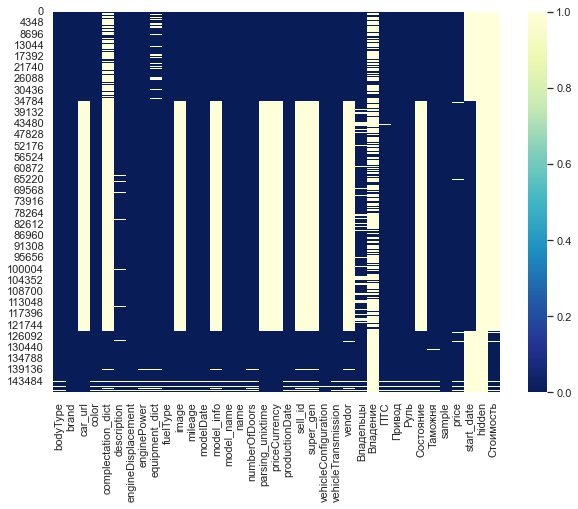

In [39]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.isnull(), cmap="YlGnBu_r");

Посмотрим на количество пропусков у признаков

In [40]:
df.isnull().sum()

bodyType                   619
brand                        0
car_url                  89378
color                      618
complectation_dict      118584
description               4285
engineDisplacement         765
enginePower                939
equipment_dict           10934
fuelType                   764
image                    89997
mileage                    618
modelDate                  619
model_info               90316
model_name                 618
name                       619
numberOfDoors              939
parsing_unixtime         89378
priceCurrency            89378
productionDate             618
sell_id                  90316
super_gen                90317
vehicleConfiguration       463
vehicleTransmission        619
vendor                   90660
Владельцы                14206
Владение                106629
ПТС                        980
Привод                     619
Руль                       618
Состояние                90019
Таможня                    661
sample  

Считаем процент пропусков в столбцах

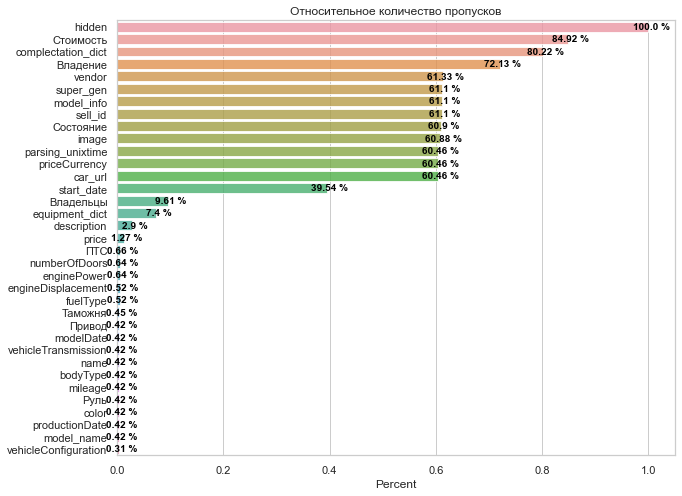

In [41]:
per_nans = pd.DataFrame(1-df.count()/df.shape[0]).reset_index().rename({0:'percent'},
                                                                       axis=1).sort_values('percent', ascending=False).query('percent>0')
fig, ax = plt.subplots(figsize = (10, 8))
bar_plot = sns.barplot(x='percent', y='index', data=per_nans, alpha=0.8, ci=None)
for ytick in bar_plot.get_yticks():
    bar_plot.text(per_nans.iloc[ytick][1]+0.005, ytick+0.2, str(round(per_nans.iloc[ytick][1]*100,2))+' %',
                  horizontalalignment='center',size=10, color='black',weight='semibold')
plt.title('Относительное количество пропусков')
plt.ylabel('')
plt.xlabel('Percent', fontsize=12)
plt.show()

## Предварительные выводы о датасете df

* В датасете ***df*** 147825 строк, соответствующих 147825 объявлениям.
* Датасет состоит из 37 столбцов: **1** типа **float64** (**parsing_unixtime**) и **34** типа **object**. Из некоторых признаков типа object возможно получится создать новые количественные признаки, поскольку наша ML модель принимает на вход только такие.
* Все признаки содержат пропуски. Необходимо либо обработать пропуски в этих признаках, либо удалить сами признаки.

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

***Информация для парсинга данных***

In [42]:
df_test.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

AUDI HONDA BMW INFINITI MERCEDES LEXUS SKODA VOLVO NISSAN TOYOTA VOLKSWAGEN MITSUBISHI

In [43]:
df_test.productionDate.min()

1904

In [44]:
df_test.productionDate.max()

2020

## анализ целевой переменной (price)

In [45]:
df[(df['sample'] == 1)]['price'].isnull().sum()

1877

удалим пропуски

In [46]:
df = df.dropna(subset=['price'])

### Создадим списки категориальных, количественных признаков, бинарных и признаков для удаления

In [47]:
cat_cols = []
num_cols = []
bin_cols = []
drop_cols = []

### Посмотрим на данные с помощью pandas_profiling

In [48]:
df_test.profile_report()

Summarize dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Детальный анализ переменных
### 1. bodyType

In [49]:
df.bodyType.isnull().sum()

1

In [50]:
print('Количество типов кузова в датасете:', df.bodyType.nunique())
df.bodyType.unique()

Количество типов кузова в датасете: 192


array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон', 'Седан', 'Универсал 5 дв.',
       'Хэтчбек 5 дв. Sportback', 'Хэтчбек 3 дв.', 'Хэтчбек 5 дв.',
       'Кабриолет', 'Купе', 'Лифтбек Sportback', 'Лифтбек', 'Седан Long',
       'Внедорожник 5 дв.', 'Кабриолет Roadster', 'Седан 2 дв.',
       'Седан Gran Coupe', 'Компактвэн', 'Компактвэн Gran Tourer',
       'Лифтбек Gran Turismo', 'Хэтчбек 3 дв. Compact',
       'Лифтбек Gran Coupe', 'Купе-хардтоп', 'Родстер Roadster',
       'Родстер', 'Внедорожник 5 дв. ESV', 'Минивэн',
       'Пикап Двойная кабина', 'Внедорожник 3 дв.',
       'Пикап Одинарная кабина', 'Тарга', 'Пикап

Постараемся объединить имеющиеся типы кузовов в группы

In [51]:
set_bodytype = {'едан':'sedan', 'этчбек':'hatchback', 'дорожник 5 дв':'SUV_5', 'ифтбек':'liftback',
                'абриолет':'cabriolet', 'дорожник 3':'SUV_3', 'икап':'pickup', 'ниверсал':'station_wagon',
                'инивэн':'minivan', 'омпактвэн':'compact_van', 'ожник откр':'SUV_open', 'упе':'coupe',
                'икровэн':'microvan', 'одстер':'roadster', 'ургон':'van', 'арга':'targa', 'музин':'limousine',
                'астбек':'fastback'}

In [52]:
replacement(set_bodytype, df, 'bodyType')
df.bodyType.unique()

array(['liftback', 'SUV_5', 'hatchback', 'sedan', 'compact_van',
       'station_wagon', 'pickup', 'coupe', 'cabriolet', 'minivan',
       'SUV_3', 'roadster', 'microvan', 'fastback', 'targa', 'SUV_open',
       'limousine', 'van', nan], dtype=object)

In [53]:
df[(df['bodyType'].isnull())]

bodyType  brand car_url   color complectation_dict  \
59310      NaN  HONDA     NaN  CACECB                NaN   

                                             description engineDisplacement  \
59310  Продаю Honda Civic Suttle 1989 г. выпуска, неу...                NaN   

      enginePower           equipment_dict   fuelType image mileage modelDate  \
59310         NaN  {'id': '0', 'name': ''}  универсал   NaN  400000       NaN   

      model_info model_name name numberOfDoors  parsing_unixtime  \
59310        NaN      CIVIC  NaN           NaN               NaN   

      priceCurrency productionDate sell_id super_gen vehicleConfiguration  \
59310           NaN           1989     NaN       NaN                  NaN   

      vehicleTransmission vendor Владельцы Владение       ПТС Привод  Руль  \
59310                 NaN    NaN       3.0      NaN  ORIGINAL    NaN  LEFT   

      Состояние Таможня  sample     price            start_date  hidden  \
59310       NaN    True       1  120000.0  2020-04-10T16:07:57Z     NaN   

      Стоимость  
59310       NaN

In [54]:
df = df.dropna(subset=['bodyType'])

Посмотрим на распределение объявлений по типу кузова

<AxesSubplot:title={'center':'Кузов vs Количество объявлений'}>

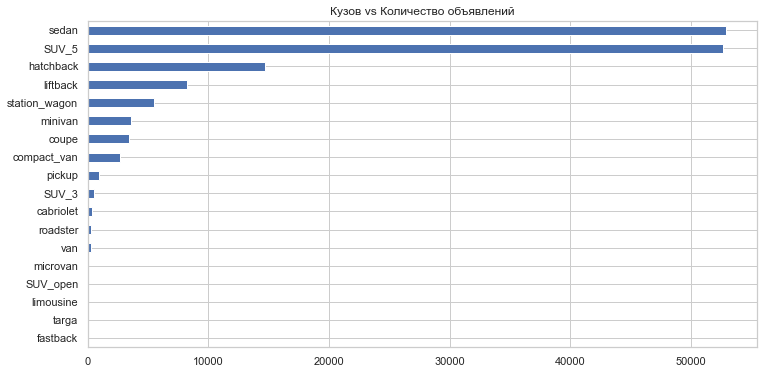

In [55]:
plt.rcParams['figure.figsize'] = (12,6)
df.bodyType.value_counts(ascending=True, dropna=False).plot(kind='barh', title = 'Кузов vs Количество объявлений')

При выборе и оценке стоимости машины тип кузова имеет значение.
Объявим "Редким" тип кузова, который встречается в датасете в менее 3% объявлений

In [56]:
list_of_bodyType = list(df.bodyType.unique())
list_of_rare_bodyType = []
for item in list_of_bodyType:
    if df[(df.bodyType == item)].bodyType.count() <= df.shape[0]*0.03:
        list_of_rare_bodyType.append(item)
df.bodyType = df.bodyType.apply(lambda x: 'rare' if x in list_of_rare_bodyType else x)

Посмотрим, что получилось

<AxesSubplot:title={'center':'Кузов vs Количество объявлений'}>

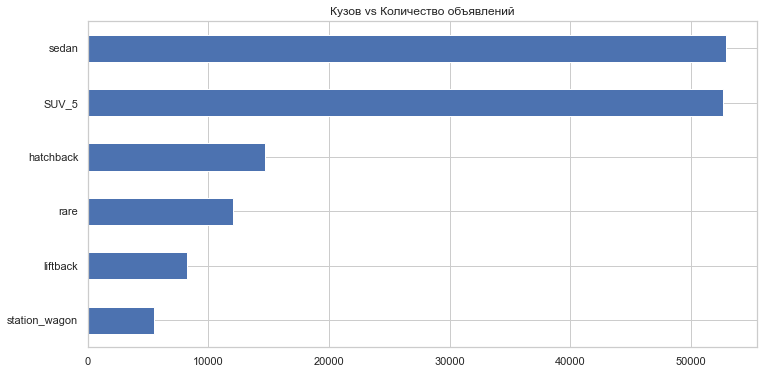

In [57]:
plt.rcParams['figure.figsize'] = (12,6)
df.bodyType.value_counts(ascending=True, dropna=False).plot(kind='barh', title = 'Кузов vs Количество объявлений')

Добавим признак bodyType в списоки

In [58]:
cat_cols.append('bodyType')
drop_cols.append('bodyType')

### 2. brand

В этом признаке нет пропусков
Посмотрим какие значения принимает признак и их количество в датасете df:

In [59]:
print('Количество брендов машин в датасете:', df.brand.nunique())
df.brand.unique()

Количество брендов машин в датасете: 46


array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI',
       'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAEWOO',
       'DODGE', 'FORD', 'GEELY', 'HYUNDAI', 'JAGUAR', 'JEEP', 'KIA',
       'MAZDA', 'MINI', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT', 'SUBARU',
       'SUZUKI', 'GREAT_WALL', 'LAND_ROVER', 'SSANG_YONG', 'audi', 'bmw',
       'honda', 'infiniti', 'mercedes', 'lexus', 'skoda', 'volvo',
       'nissan', 'chery'], dtype=object)

Мы видим, что одни и те же бренды записаны в разном регистре, исправим это:

In [60]:
df.brand = df.brand.str.lower()
print('Количество брендов машин в датасете:', df.brand.nunique())
df.brand.unique()

Количество брендов машин в датасете: 36


array(['skoda', 'audi', 'honda', 'volvo', 'bmw', 'nissan', 'infiniti',
       'mercedes', 'toyota', 'lexus', 'volkswagen', 'mitsubishi',
       'cadillac', 'chery', 'chevrolet', 'chrysler', 'citroen', 'daewoo',
       'dodge', 'ford', 'geely', 'hyundai', 'jaguar', 'jeep', 'kia',
       'mazda', 'mini', 'opel', 'peugeot', 'porsche', 'renault', 'subaru',
       'suzuki', 'great_wall', 'land_rover', 'ssang_yong'], dtype=object)

Посмотрим на распределение объявлений по brand

<AxesSubplot:title={'center':'Бренд vs Количество объявлений'}>

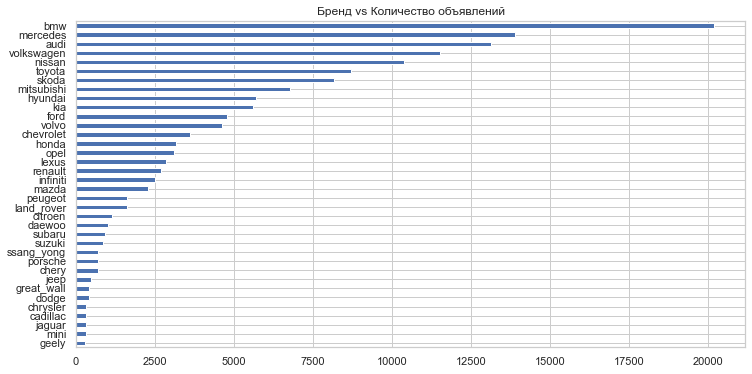

In [61]:
plt.rcParams['figure.figsize'] = (12,6)
df.brand.value_counts(ascending=True, dropna=False).plot(kind='barh', title = 'Бренд vs Количество объявлений')

Добавим признак brand в списоки

In [62]:
cat_cols.append('brand')
drop_cols.append('brand')

### 3. car_url

In [63]:
df.car_url[0]

'https://auto.ru/cars/used/sale/skoda/octavia/1100575026-c780dc09/'

Это ссылка на страницу с объявлением. Для последующего предсказания стоимости авто этот признак неинформативен
Добавим признак car_url в список drop_cols:

In [64]:
drop_cols.append('car_url')

### 4. color

In [65]:
df.color.unique()

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый',
       '040001', 'EE1D19', '0000CC', 'CACECB', '007F00', 'FAFBFB',
       '97948F', '22A0F8', '660099', '200204', 'C49648', 'DEA522',
       '4A2197', 'FFD600', 'FF8649', 'FFC0CB'], dtype=object)

Посмотрим пропуски

In [66]:
df.color.isnull().sum()

0

Постараемся объединить имеющиеся цвета:

In [67]:
set_colors = {'FFC0CB':'pink', 'розовый':'pink', 'синий':'blue', 'чёрный':'black', 'серый':'gray',
              'коричневый':'brown', 'белый':'white', 'пурпурный':'purple', 'бежевый':'beige',
              'серебристый':'silver', 'красный':'red', 'зелёный':'green', 'жёлтый':'yellow',
              'голубой':'blue', 'оранжевый':'orange', 'фиолетовый':'purple', 'золотистый':'gold',
              '040001':'red', 'EE1D19':'red', '0000CC':'blue', 'CACECB':'gray', '007F00':'green',
              'FAFBFB':'blue', '97948F':'gray', '22A0F8':'blue', '660099':'purple', '200204':'purple',
              'C49648':'brown', 'DEA522':'brown', '4A2197':'purple', 'FFD600':'yellow', 'FF8649':'coral',
              'FFC0CB':'pink'}

In [68]:
replacement_1(set_colors, df, 'color')

Посмотрим, что получилось

In [69]:
df.color.value_counts(dropna=False)

blue      32512
red       32039
gray      29243
black     18465
white     10770
purple     5588
silver     5230
brown      5174
green      3859
yellow      966
beige       925
coral       515
gold        338
orange      277
pink         46
Name: color, dtype: int64

Объявим редким цвет, который встречается в датасете в менее 5% объявлений

In [70]:
list_of_colors = list(df.color.unique())
list_of_rare_colors = []
for item in list_of_colors:
    if df[(df.color == item)].color.count() <= df.shape[0]*0.05:
        list_of_rare_colors.append(item)
df.color = df.color.apply(lambda x: 'rare' if x in list_of_rare_colors else x)

Посмотрим, что получилось

<AxesSubplot:title={'center':'Цвет машины vs Количество объявлений'}>

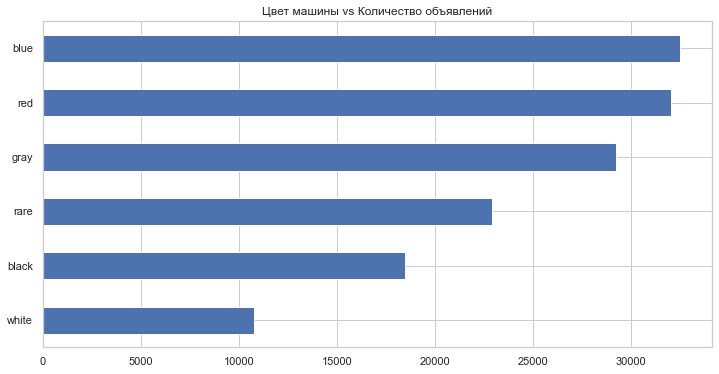

In [71]:
plt.rcParams['figure.figsize'] = (12,6)
df.color.value_counts(ascending=True, dropna=False).plot(kind='barh', title = 'Цвет машины vs Количество объявлений')

Добавим признак color в списоки

In [72]:
cat_cols.append('color')
drop_cols.append('color')

### 5. complectation_dict

In [73]:
df.complectation_dict[5]

'{"id":"5011515","name":"RS","available_options":["cruise-control","sport-seats","multi-wheel","airbag-passenger","lock","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","audiopreparation","electro-window-back","condition","music-super","park-assist-r","airbag-driver","isofix","aux","electro-window-front","light-sensor","alarm","paint-metallic","ptf","rain-sensor","tyre-pressure","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo"]}'

In [74]:
df.complectation_dict = df.complectation_dict.apply(dict_to_list)
df.complectation_dict[5]

['cruise-control',
 'sport-seats',
 'multi-wheel',
 'airbag-passenger',
 'lock',
 'electro-mirrors',
 'mirrors-heat',
 'cooling-box',
 'computer',
 'seat-transformation',
 'wheel-power',
 'fabric-seats',
 'airbag-side',
 'abs',
 'wheel-leather',
 'climate-control-1',
 'esp',
 'audiopreparation',
 'electro-window-back',
 'condition',
 'music-super',
 'park-assist-r',
 'airbag-driver',
 'isofix',
 'aux',
 'electro-window-front',
 'light-sensor',
 'alarm',
 'paint-metallic',
 'ptf',
 'rain-sensor',
 'tyre-pressure',
 'audiosystem-cd',
 'front-seats-heat',
 'wheel-configuration2',
 'wheel-configuration1',
 'immo']

Посмотрим общее колличество уникальных элементов

In [75]:
df.complectation_dict.explode().nunique()

367

Признак complectation_dict имеет 80.22% пропусков, но информация о комплектации содержится
ещё в одном признаке - в 'equipment_dict', возможно, они дополнят друг друга!
Добавим его в список drop_cols:

In [76]:
drop_cols.append('complectation_dict')

### 6. description

In [77]:
df.description[0]

'Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!\n\nПреимущества автокредитования:\n— Первоначальный взнос от 0%;\n— Более 30 кредитных программ;\n— Процентная ставка от 6% годовых;\n— Срок кредита от 6 месяцев до 7 лет;\n— Оформление кредита по двум документам;\n— Досрочное погашение без штрафов и комиссий;\n— Сумма кредита до 2 млн рублей;\n— Оформление КАСКО – по желанию;\n— Без справок и поручителей.\n\nСотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nПри покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!\n\nЗаписаться на тест-драйв, а так же получить подробную информацию можно у специалистов автоцентра по указанно

In [78]:
df.description.isnull().sum()

3644

Для последующего предсказания стоимости авто этот признак неинформативен
Добавим признак description в список drop_cols:

In [79]:
drop_cols.append('description')

### 7. engineDisplacement

Признак engineDisplacement показывает, какой объём двигателя у продаваемой машины

In [80]:
df.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', ..., '4.4 л / 635 л.с. /',
       '3.4 л / 192 л.с. /', '4.4 л / 462 л.с. /'], dtype=object)

Количество пропусков

In [81]:
len(df.loc[(df.engineDisplacement.isnull())])

145

При осмотре признаков выяснилось, что в признаке 'name' есть технические характеристики автомобиля, в том числе информация об объёме двигателя

In [82]:
df.loc[(df.engineDisplacement.isnull())]['name'].unique()

array(['50 Electro AT (220 кВт) 4WD', 'Electro AT (370 кВт) 4WD',
       '55 Electro AT (300 кВт) 4WD', '50 Electro AT (230 кВт) 4WD',
       'Electro AT (390 кВт) 4WD', 'Electro AT (475 кВт) 4WD',
       '94Ah Electro AT (125 кВт)', '94Ah S Electro AT (135 кВт)',
       'xDrive40 Electro AT (240 кВт) 4WD',
       '120Ah S Electro AT (135 кВт)', '60Ah Electro AT (125 кВт)',
       '120Ah Electro AT (125 кВт)', 'Electro AT (113 кВт)',
       '300 Extra-long Electro AT (150 кВт)',
       '300 Long Electro AT (150 кВт)', 'Electro AT (80 кВт)'],
      dtype=object)

In [83]:
df.engineDisplacement = df.engineDisplacement.apply(engine_displacement)

Смотрим, что получилось

In [84]:
df['engineDisplacement'].unique()

array([1.2, 1.6, 1.8, 2. , 1.4, 1.3, 1. , 3.6, 1.5, 1.9, 2.8, 1.1, 2.5,
       4.2, 3. , 4. , 5.9, 2.7, 3.1, 2.4, 5.2, 3.2, 4.1, 6.3, 2.3, 6. ,
       2.2, 3.7, 2.9, 5. , 3.3, 2.1, 2.6, 0. , 3.5, 1.7, 0.7, 4.4, 4.8,
       5.4, 6.6, 4.9, 3.8, 3.4, 3.9, 4.6, 5.6, 4.5, 5.5, 6.2, 4.7, 4.3,
       5.8, 5.3, 5.7, 6.4, 8.2, 7. , 0.8, 8.1, 7.5, 7.4, 6.5, 6.8, 6.7,
       7.3, nan])

Сделаем замену в пропусков в engineDisplacement значением 0, поскольку,
как видно из признака name, это электромобили, и они имеют нулевой объём двигателя

In [85]:
df.engineDisplacement = df.engineDisplacement.fillna(0)

<Figure size 864x432 with 0 Axes>

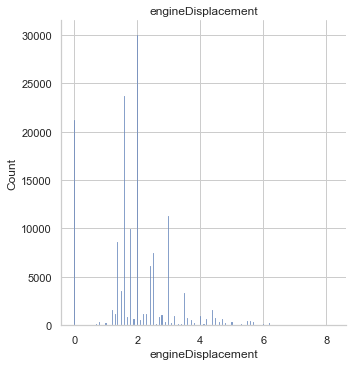

In [86]:
plt.figure()
sns.displot(df['engineDisplacement'], kde = False, rug=False)
plt.title('engineDisplacement')
plt.show()

Посмотрим на выбросы

In [87]:
IQR_outlier(df, 'engineDisplacement', verbose=True)

Для признака engineDisplacement :
25-й перцентиль: 1.5 75-й перцентиль: 2.4, IQR: 0.8999999999999999,  Границы выбросов: [0.15000000000000013, 3.75].
Выбросов, согласно IQR: 28899 | 19.80%


***В последующем мы прологарифмируем числовые переменные, чтобы сгладить разницу в размерности и уменьшить выбросы***
Добавим признак engineDisplacement в список num_cols:

In [88]:
num_cols.append('engineDisplacement')

### 8. enginePower

In [89]:
df.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

Посчитаем, сколько пропусков

In [90]:
df.enginePower.isnull().sum()

311

Признак enginePower показывает, какая мощность двигателя у продаваемой машины
Переведем его из формата object в формат float

In [91]:
df.enginePower = df.enginePower.apply(enginePower)

Заполним пропуски данными из признака 'name'

In [92]:
df[(df.enginePower.isnull())]['name'].unique()

array(['2.0 AT (249 л.с.) 4WD', '1.5 CVT (147 л.с.)', '1.3 MT (83 л.с.)',
       '1.5 CVT (113 л.с.)', '1.9 MT (132 л.с.)', '2.0 CVT (170 л.с.)',
       '1.6 MT (88 л.с.)', '2.0 MT (136 л.с.)', '1.5 MT (109 л.с.)',
       '2.0 CVT (139 л.с.)', '1.3 AMT (83 л.с.)', '1.6 AMT (186 л.с.)',
       '1.6 CVT (126 л.с.)', '2.0 MT (130 л.с.)', '2.4 MT (129 л.с.)',
       '1.9 AMT (132 л.с.)', '1.6 MT (126 л.с.)', '1.6 MT (119 л.с.)',
       '1.5 MT (106 л.с.)', '1.5 AMT (147 л.с.)', '2.0 CVT (122 л.с.)',
       '0.8 MT (52 л.с.)', '2.0 CVT (136 л.с.)', '2.0 AT (125 л.с.)',
       '1.1 MT (68 л.с.)', '2.0 AT (136 л.с.)', '2.4 MT (129 л.с.) 4WD',
       '0.8 AMT (52 л.с.)', '1.6 MT (94 л.с.)', '1.8 AT (132 л.с.)',
       '20d xDrive 2.0d AT (190 л.с.) 4WD', '30d 3.0d AT (245 л.с.) 4WD',
       '30d 3.0d AT (249 л.с.) 4WD', '530d xDrive 3.0d AT (249 л.с.) 4WD',
       '30d xDrive 3.0d AT (249 л.с.) 4WD', '35i 3.0 AT (306 л.с.) 4WD',
       '25d 3.0d AT (218 л.с.) 4WD', '118i 1.6 AT (170 л.с.)',
  

In [93]:
df_2 = df.loc[df.enginePower.isnull()].copy()

In [94]:
df_2.enginePower = df_2.name.apply(enginePower_nan)

In [95]:
df.loc[df.enginePower.isnull()] = df_2.copy()

<Figure size 864x432 with 0 Axes>

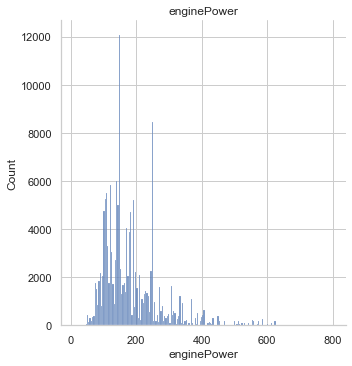

In [96]:
plt.figure()
sns.displot(df['enginePower'], kde = False, rug=False)
plt.title('enginePower')
plt.show()

Посмотрим на выбросы

In [97]:
IQR_outlier(df, 'enginePower', verbose=True)

Для признака enginePower :
25-й перцентиль: 122.0 75-й перцентиль: 224.0, IQR: 102.0,  Границы выбросов: [-31.0, 377.0].
Выбросов, согласно IQR: 6122 | 4.19%


Выбросов немного, и, скорее всего, это не ошибочные значения. Мы потом сгладим разницу в значениях **логарифмированием**
Посмотрим на авто с максимальной мощностью двигателя:

In [98]:
df[(df.enginePower==df.enginePower.max())]

bodyType     brand car_url color complectation_dict  \
118662    SUV_5  mercedes     NaN   red               None   

                                              description  engineDisplacement  \
118662  BRABUS G800 WIDESTAR на базе G63\n800 л.с.\n\n...                 0.0   

        enginePower                                     equipment_dict  \
118662        800.0  {'id': '21715492', 'name': 'Individual', 'avai...   

       fuelType image mileage modelDate model_info    model_name  \
118662   бензин   NaN       0    2018.0        NaN  G_KLASSE_AMG   

                                    name numberOfDoors  parsing_unixtime  \
118662  Brabus 800 4.0 AT (800 л.с.) 4WD           5.0               NaN   

       priceCurrency productionDate sell_id super_gen  \
118662           NaN           2020     NaN       NaN   

                    vehicleConfiguration vehicleTransmission vendor Владельцы  \
118662  ALLROAD_5_DOORS AUTOMATIC Brabus           AUTOMATIC    NaN       NaN   

       Владение  ПТС  Привод  Руль Состояние Таможня  sample       price  \
118662      NaN  NaN  полный  LEFT       NaN    True       1  31600000.0   

                  start_date  hidden Стоимость  
118662  2020-04-04T15:24:25Z     NaN       NaN

Действительно такая мощность двигателя существует
Добавим признак enginePower в список num_cols:

In [99]:
num_cols.append('enginePower')

### 9. equipment_dict

- Признак имеет пропуски - 10934 (7.4%). Большинство этих пропусков находится в нашем датасете test (до 26%) Посмотрим, возможно объединение признака equipment_dict и complectation_dict

In [100]:
df.equipment_dict[100]

'{"cruise-control":true,"engine-proof":true,"asr":true,"tinted-glass":true,"esp":true,"airbag-driver":true,"usb":true,"aux":true,"electro-window-front":true,"light-sensor":true,"multi-wheel":true,"airbag-curtain":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"high-beam-assist":true,"computer":true,"roof-rails":true,"seat-transformation":true,"wheel-power":true,"alarm":true,"lock":true,"fabric-seats":true,"electro-mirrors":true,"airbag-rear-side":true,"electro-window-back":true,"alloy-wheel-disks":true,"leather-gear-stick":true,"16-inch-wheels":true,"ptf":true,"rain-sensor":true,"airbag-side":true,"mirrors-heat":true,"dark-interior":true,"audiosystem-cd":true,"abs":true,"front-seats-heat":true,"power-child-locks-rear-doors":true,"bluetooth":true,"wheel-leather":true,"wheel-configuration2":true,"wheel-configuration1":true,"immo":true,"windscreen-heat":true,"climate-control-2":true,"park-assist-r":true,"12v-socket":true,"knee-airbag":true}'

In [101]:
df.equipment_dict.isnull().sum()

10307

In [102]:
df.equipment_dict = df.equipment_dict.apply(equipment_dict_to_list)
df.equipment_dict[100]

['cruise-control',
 'engine-proof',
 'asr',
 'tinted-glass',
 'esp',
 'airbag-driver',
 'usb',
 'aux',
 'electro-window-front',
 'light-sensor',
 'multi-wheel',
 'airbag-curtain',
 'ashtray-and-cigarette-lighter',
 'airbag-passenger',
 'high-beam-assist',
 'computer',
 'roof-rails',
 'seat-transformation',
 'wheel-power',
 'alarm',
 'lock',
 'fabric-seats',
 'electro-mirrors',
 'airbag-rear-side',
 'electro-window-back',
 'alloy-wheel-disks',
 'leather-gear-stick',
 '16-inch-wheels',
 'ptf',
 'rain-sensor',
 'airbag-side',
 'mirrors-heat',
 'dark-interior',
 'audiosystem-cd',
 'abs',
 'front-seats-heat',
 'power-child-locks-rear-doors',
 'bluetooth',
 'wheel-leather',
 'wheel-configuration2',
 'wheel-configuration1',
 'immo',
 'windscreen-heat',
 'climate-control-2',
 'park-assist-r',
 '12v-socket',
 'knee-airbag']

Общее колличество уникальных элементов

In [103]:
df.equipment_dict.explode().nunique()

296

Создадим новый признак, объединив equipment_dict и complectation_dict

In [104]:
df_tmp = df.apply(complectation_new, axis=1)

Поспотрим на оставшиеся пропуски.

In [105]:
df_tmp[df_tmp.complectation_new == 'not known']

bodyType  brand                                            car_url  \
58       liftback  skoda  https://auto.ru/cars/used/sale/skoda/octavia/1...   
81       liftback  skoda  https://auto.ru/cars/used/sale/skoda/octavia/1...   
85       liftback  skoda  https://auto.ru/cars/used/sale/skoda/octavia/1...   
90      hatchback  skoda  https://auto.ru/cars/used/sale/skoda/fabia/110...   
99       liftback  skoda  https://auto.ru/cars/used/sale/skoda/superb/11...   
...           ...    ...                                                ...   
147820      SUV_5    bmw  https://auto.ru/cars/used/sale/bmw/x3/11062041...   
147821      SUV_5    bmw  https://auto.ru/cars/used/sale/bmw/x3/11062801...   
147822      SUV_5    bmw  https://auto.ru/cars/used/sale/bmw/x5/11065753...   
147823      sedan    bmw  https://auto.ru/cars/used/sale/bmw/5er/1114693...   
147824      sedan    bmw  https://auto.ru/cars/used/sale/bmw/3er/1114845...   

        color complectation_dict  \
58      white                 {}   
81      black                 {}   
85      white                 {}   
90       gray                 {}   
99       blue                 {}   
...       ...                ...   
147820  white                 {}   
147821   blue                 {}   
147822   gray                 {}   
147823   rare                 {}   
147824    red                 {}   

                                              description  engineDisplacement  \
58                                         Срочно Продам.                 1.6   
81      Хорошее состояние , бережная  эксплуатация,  2...                 1.8   
85      Все автомобили, для Вашего удобства, находятся...                 1.2   
90      Все автомобили, для Вашего удобства, находятся...                 1.6   
99      Вашему вниманию представляется автомобиль Skod...                 1.4   
...                                                   ...                 ...   
147820  По технике в идеале. Мотор масло не ест совсем...                 3.0   
147821  Все автомобили, для Вашего удобства, находятся...                 2.0   
147822  Машина в идеальном состоянии, любые проверки з...                 3.0   
147823  На ходу, оригинальный птс, с 2009 года в одних...                 2.8   
147824  АВТОРАССРОЧКА НА АВТОМОБИЛИ С ПРОБЕГОМ 0%!*\nП...                 1.6   

        enginePower equipment_dict fuelType  \
58            110.0             {}   бензин   
81            152.0             {}   бензин   
85            105.0             {}   бензин   
90            105.0             {}   бензин   
99            150.0             {}   бензин   
...             ...            ...      ...   
147820        249.0             {}   Дизель   
147821        184.0             {}   Бензин   
147822        218.0             {}   Дизель   
147823        193.0             {}   Бензин   
147824        136.0             {}   Бензин   

                                                    image mileage modelDate  \
58      https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...  150200    2013.0   
81      https://avatars.mds.yandex.net/get-autoru-vos/...  229300    2008.0   
85      https://avatars.mds.yandex.net/get-autoru-vos/...   96000    2013.0   
90      https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...  152000    2010.0   
99      https://avatars.mds.yandex.net/get-autoru-vos/...   64704    2015.0   
...                                                   ...     ...       ...   
147820  [https://avatars.mds.yandex.net/get-autoru-vos...  198000      2012   
147821  [https://avatars.mds.yandex.net/get-autoru-vos...   60970      2018   
147822  [https://avatars.mds.yandex.net/get-autoru-vos...  170000      2016   
147823  [https://avatars.mds.yandex.net/get-autoru-vos...  330000      1997   
147824  [https://avatars.mds.yandex.net/get-autoru-vos...  128120      2013   

                                               model_info model_name  \
58      {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA

пропусков осталось много.
Добавим признак equipment_dict в список drop_cols

In [106]:
drop_cols.append('equipment_dict')

### 10.fuelType

Посмотрим какие значения принимает признак и их количество в датасете df

In [107]:
print('Количество типов топлива в датасете:', df.fuelType.nunique())
df.fuelType.value_counts(dropna=False)

Количество типов топлива в датасете: 9


бензин                                103311
дизель                                 19641
Бензин                                 16056
Дизель                                  5872
гибрид                                   517
электро                                  166
NaN                                      145
Гибрид                                   141
Бензин, газобаллонное оборудование        80
газ                                       18
Name: fuelType, dtype: int64

Мы видим, что один и тот же тип топлива записан в разных регистрах, исправим это:

In [108]:
df.fuelType = df.fuelType.str.lower()

In [109]:
set_fuel = {'бензин':'petrol', 'дизель':'diesel', 'гибрид':'hybrid', 'электро':'electro', 'газ':'gas',
            'бензин, газобаллонное оборудование':'gbo'}

In [110]:
replacement_1(set_fuel, df, 'fuelType')

In [111]:
df.fuelType.unique()

array(['petrol', 'diesel', 'hybrid', 'electro', 'gas', None, 'gbo'],
      dtype=object)

In [112]:
df[(df['fuelType'].isnull())]['name']

124079          50 Electro AT (220 кВт) 4WD
124082          50 Electro AT (220 кВт) 4WD
124266             Electro AT (370 кВт) 4WD
124323          50 Electro AT (220 кВт) 4WD
124325          55 Electro AT (300 кВт) 4WD
                        ...                
147457           120Ah Electro AT (125 кВт)
147490    xDrive40 Electro AT (240 кВт) 4WD
147547    xDrive40 Electro AT (240 кВт) 4WD
147603    xDrive40 Electro AT (240 кВт) 4WD
147624           120Ah Electro AT (125 кВт)
Name: name, Length: 145, dtype: object

Мы видим, что в признаке name есть данные о том,
какой тип двигателя у нас, из чего мы можем сделать выводы о типе топлива

In [113]:
df_ft = df.loc[df.fuelType.isnull()].copy()
df_ft.fuelType= df_ft.name.apply(lambda x: 'electro')
df.loc[df.fuelType.isnull()] = df_ft.copy()

Посмотрим сейчас на пропуски

In [114]:
df.fuelType.isnull().sum()

0

Посмотрим, что получилось

<AxesSubplot:title={'center':'Тип топлива vs Количество объявлений'}>

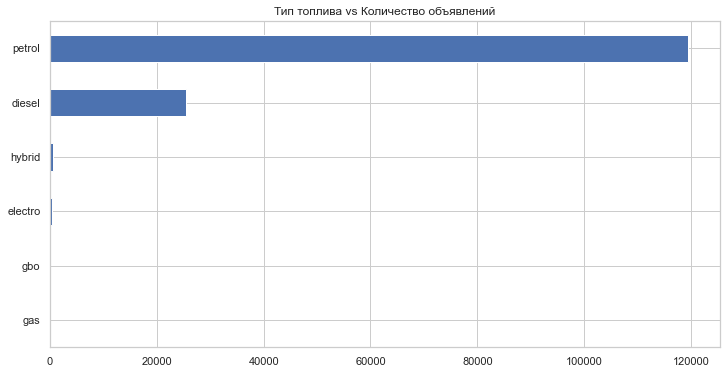

In [115]:
plt.rcParams['figure.figsize'] = (12,6)
df.fuelType.value_counts(ascending=True, dropna=False).plot(kind='barh', title = 'Тип топлива vs Количество объявлений')

Добавим признак fuelType в списоки

In [116]:
cat_cols.append('fuelType')
drop_cols.append('fuelType')

### 11.image

In [117]:
df.image[0]

'https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u0IghxJHqVi5dGL7OcugpPbM0sYLDhB9YWw7CxRKU17ysuJYxu9oaUHn7ahNSrqiKwm-CQDyDolDeEoEc3J49fgWYNYBUbQC7D96sj6K9_O-mo6XT34oWVQDBTEybGZikaX4X4bwLyUujf_KICqw3ygs2UNJlXu4Og#DSD'

Тестовая выборка была получена в 2020 году, поэтому информация о фото с сайта скорее всего неактувльна
Добавим признак image в список drop_cols:

In [118]:
drop_cols.append('image')

### 12. mileage

In [119]:
df.mileage.isnull().sum()

0

Признак **mileage** не имеет пропусков

In [120]:
df.mileage.unique()

array([74000, 60563, 88000, ..., '125803', '136900', '82400'],
      dtype=object)

In [121]:
df.mileage = df.mileage.apply(lambda x: int(x))

<Figure size 864x432 with 0 Axes>

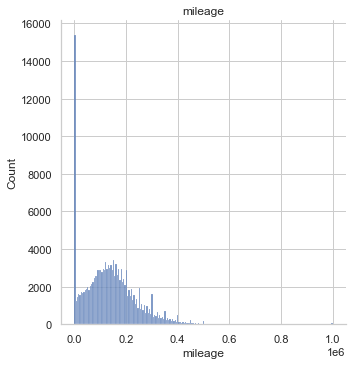

In [122]:
plt.figure()
sns.displot(df['mileage'], kde = False, rug=False)
plt.title('mileage')
plt.show()

Посмотрим на выбросы

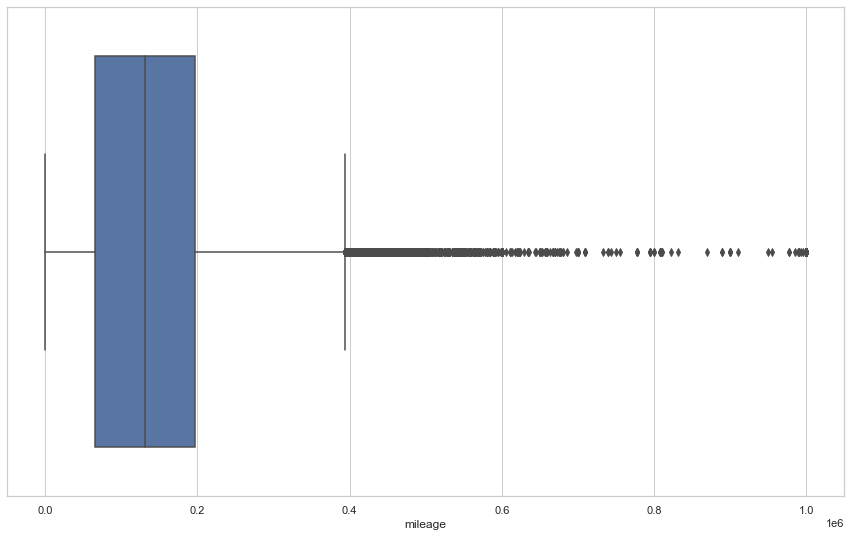

Для признака mileage :
25-й перцентиль: 66000.0 75-й перцентиль: 197000.0, IQR: 131000.0,  Границы выбросов: [-130500.0, 393500.0].
Выбросов, согласно IQR: 2678 | 1.83%


In [123]:
plt.figure(figsize=(15, 9))
sns.boxplot(data=df, x='mileage')
plt.show()
IQR_outlier(df, 'mileage', verbose=True)

Посмотрим на авто с максимальным пробегом и их количество:

In [124]:
print('Количество машин с пробегом 1000000 км:', len(df[(df.mileage == df.mileage.max())]))
df.mileage.max()

Количество машин с пробегом 1000000 км: 29


1000000

Это, в основном, старые автомобили, у которых пробег, наверняка, на счётчике одометра достиг максимума (максимум одометра это 999999 км). В последующем мы **прологорифмируем** признак, постараясь уменьшить выбросы и сгладить разброс в размерности количесивенных признакоы

Добавим признак mileage в список num_cols:

In [125]:
num_cols.append('mileage')

### 13.modelDate

In [126]:
df.modelDate.unique()

array([2013.0, 2017.0, 2008.0, 2009.0, 2016.0, 2012.0, 2015.0, 2010.0,
       2006.0, 2000.0, 2007.0, 1994.0, 2004.0, 1999.0, 2005.0, 1976.0,
       2001.0, 1969.0, 1996.0, 1998.0, 1989.0, 1934.0, 2014.0, 2011.0,
       2018.0, 1986.0, 1997.0, 1990.0, 2019.0, 2002.0, 1991.0, 1987.0,
       1980.0, 1982.0, 1938.0, 1988.0, 2003.0, 1983.0, 1978.0, 1979.0,
       1984.0, 1992.0, 1995.0, 1993.0, 1985.0, 1974.0, 1966.0, 1977.0,
       1981.0, 1972.0, 1968.0, 1975.0, 1949.0, 1937.0, 1936.0, 1973.0,
       1959.0, 1958.0, 2020.0, 1965.0, 1971.0, 1904.0, 1963.0, 1955.0,
       1951.0, 1960.0, 1956.0, 1970.0, 1964.0, 1957.0, 1927.0, 1908.0,
       1932.0, 1935.0, 1967.0, 1948.0, 1950.0, 1961.0, '2012', '2018',
       '2013', '2011', '2008', '2014', '2019', '2021', '2007', '2016',
       '2009', '2004', '2010', '2020', '2015', '2017', '1994', '2003',
       '1998', '2006', '2000', '1990', '2005', '1996', '2001', '1991',
       '1988', '1995', '1993', '1989', '2002', '2022', '1999', '1997',
      

In [127]:
df.modelDate.isnull().sum()

0

In [128]:
df.modelDate = df.modelDate.apply(model_date)

In [129]:
df.modelDate.value_counts()

2010    9193
2006    8591
2017    8410
2009    8347
2011    8169
        ... 
1969       2
1935       1
1967       1
1948       1
1946       1
Name: modelDate, Length: 82, dtype: int64

<Figure size 864x432 with 0 Axes>

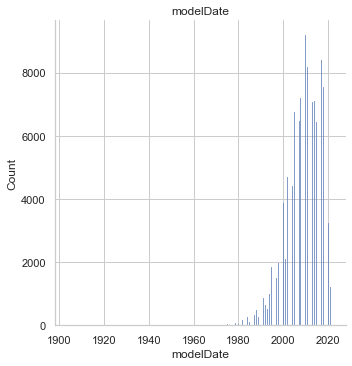

In [130]:
plt.figure()
sns.displot(df['modelDate'], kde = False, rug=False)
plt.title('modelDate')
plt.show()

Посмотрим на выбросы:

In [131]:
IQR_outlier(df, 'modelDate', verbose=True)

Для признака modelDate :
25-й перцентиль: 2005.0 75-й перцентиль: 2014.0, IQR: 9.0,  Границы выбросов: [1991.5, 2027.5].
Выбросов, согласно IQR: 4154 | 2.85%


Судя по всему, все выбросы у нижней границы. Посмотрим какого года самое старое авто у каждого бренда:

(1880.0, 2020.0)

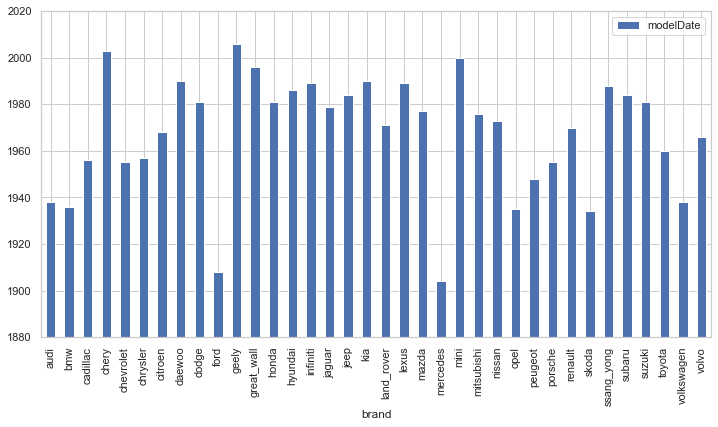

In [132]:
df.pivot_table(values = ['modelDate'],
               index = 'brand',
               aggfunc = 'min').plot(kind = 'bar')
plt.ylim([1880, 2020])

**Вывод:** Это просто действительно старые авто, и мы уменьшим разброс данных последующим **логарифмированием**
Добавим признак modelDate в список num_cols:

In [133]:
num_cols.append('modelDate')

### 14.model_info

In [134]:
df.model_info[0]

'{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

Опережая события, скажем, что признак **model_info** дублирует признак **model_name**.
Добавим признак model_info в список drop_cols:

In [135]:
drop_cols.append('model_info')

### 15. model_name

In [136]:
df.model_name.isnull().sum()

0

Посмотрим на самые распростанённые модели автомобилей:

In [137]:
model_list = list(df.model_name.values)
Counter(model_list).most_common(10)

[('BMW', 8343),
 ('Audi', 5656),
 ('OCTAVIA', 2910),
 ('5ER', 2695),
 ('Skoda', 2640),
 ('FOCUS', 2458),
 ('E_KLASSE', 2235),
 ('PASSAT', 2176),
 ('3ER', 2166),
 ('POLO', 2016)]

Объявим редкой модель, которая встречается в датасете в менее 1% объявлений:

In [138]:
models = list(df.model_name.unique())
list_of_rare_models = []
for item in models:
    if df[(df.model_name == item)].model_name.count() <= df.shape[0]*0.01:
        list_of_rare_models.append(item)
df.model_name = df.model_name.apply(lambda x: 'rare' if x in list_of_rare_models else x)

Создадим новый признак brand_model, объединив признаки brand и model_name:

In [139]:
df['model'] = df.apply(lambda x: x.brand + '_' + x.model_name, axis=1)

Посмотрим как выглядят значения в нашем новом признаке:

In [140]:
print(df.model.nunique())
df.model.unique()

58


array(['skoda_OCTAVIA', 'skoda_rare', 'audi_rare', 'audi_A6',
       'honda_rare', 'volvo_rare', 'bmw_X5', 'bmw_rare', 'bmw_5ER',
       'bmw_3ER', 'nissan_rare', 'nissan_QASHQAI', 'nissan_X_TRAIL',
       'infiniti_rare', 'mercedes_rare', 'mercedes_E_KLASSE',
       'toyota_CAMRY', 'toyota_rare', 'lexus_rare', 'volkswagen_rare',
       'volkswagen_TIGUAN', 'volkswagen_PASSAT', 'volkswagen_POLO',
       'mitsubishi_rare', 'mitsubishi_OUTLANDER', 'mitsubishi_LANCER',
       'cadillac_rare', 'chery_rare', 'chevrolet_rare', 'chrysler_rare',
       'citroen_rare', 'daewoo_rare', 'dodge_rare', 'ford_rare',
       'ford_FOCUS', 'geely_rare', 'hyundai_rare', 'hyundai_SOLARIS',
       'jaguar_rare', 'jeep_rare', 'kia_rare', 'kia_RIO', 'mazda_rare',
       'mini_rare', 'opel_rare', 'opel_ASTRA', 'peugeot_rare',
       'porsche_rare', 'renault_rare', 'subaru_rare', 'suzuki_rare',
       'great_wall_rare', 'land_rover_rare', 'ssang_yong_rare',
       'audi_Audi', 'bmw_BMW', 'mercedes_Mercedes-Ben

Отредактируем списки

In [141]:
cat_cols.append('model')
cat_cols.remove('brand')
drop_cols.append('model')
drop_cols.append('model_name')

### 16. name

Посмотрим, как выглядят и что из себя представляют данные:

In [142]:
df.name[0]

'1.2 AMT (105 л.с.)'

Признак name полностью дублирует информацию представленную в трёх других признаках, а именно в vehicleTransmission, engineDisplacement и enginePower
Добавим признак name в список drop_cols:

In [143]:
drop_cols.append('name')

### 17. numberOfDoors

Признак numberOfDoors количественный, не имеет пропусков
Посмотрим, какие значения принимает:

In [144]:
df.numberOfDoors.unique()

array([5.0, 4.0, 2.0, 3.0, 0.0, '5', '4', '2', '3', '', None],
      dtype=object)

In [145]:
doors_dict = {'5':5.0, '4':4.0, '3':3.0, '2':2.0, '':None}

In [146]:
replacement_1(doors_dict, df, 'numberOfDoors')

Заменим пропуски модой

In [147]:
df.numberOfDoors = df.numberOfDoors.fillna(df.numberOfDoors.mode()[0])

In [148]:
df.numberOfDoors.value_counts(dropna = False)

5.0    83238
4.0    55443
2.0     4197
3.0     3067
0.0        2
Name: numberOfDoors, dtype: int64

Посмотрим на подозрительную модель без дверей

In [149]:
df[(df.numberOfDoors == 0)]

bodyType     brand                                            car_url  \
16944      rare  mercedes  https://auto.ru/cars/used/sale/mercedes/simple...   
122751     rare  mercedes                                                NaN   

        color complectation_dict  \
16944   white               None   
122751   blue               None   

                                              description  engineDisplacement  \
16944   на ходу. 1904 год. стоит в гараже, пылится.Кат...                 5.3   
122751  на ходу. 1904 год. стоит в гараже, пылится.Кат...                 5.3   

        enginePower equipment_dict fuelType  \
16944          32.0             []   petrol   
122751         32.0             []   petrol   

                                                    image  mileage  modelDate  \
16944   https://autoru.naydex.net/ESooa9149/468b9eoMem...    48000       1904   
122751                                                NaN    48000       1904   

                                               model_info model_name  \
16944   {"code":"SIMPLEX","name":"Simplex","ru_name":"...       rare   
122751                                                NaN       rare   

                    name  numberOfDoors  parsing_unixtime priceCurrency  \
16944   5.3 MT (32 л.с.)            0.0      1.603246e+09           RUB   
122751  5.3 MT (32 л.с.)            0.0               NaN           NaN   

       productionDate       sell_id  \
16944            1904  1093802104.0   
122751           1904           NaN   

                                                super_gen  \
16944   {"id":"21743990","displacement":5322,"engine_t...   
122751                                                NaN   

         vehicleConfiguration vehicleTransmission    vendor   Владельцы  \
16944   CABRIO MECHANICAL 5.3        механическая  EUROPEAN  1 владелец   
122751  CABRIO MECHANICAL 5.3          MECHANICAL       NaN         1.0   

                          Владение       ПТС  Привод    Руль  \
16944            6 лет и 8 месяцев  Оригинал  задний  Правый   
122751  {'year': 2014, 'month': 2}  ORIGINAL  задний   RIGHT   

                 Состояние     Таможня  sample       price  \
16944   Не требует ремонта  Растаможен       0         0.0   
122751                 NaN        True       1  12000000.0   

                  start_date  hidden Стоимость          model  
16944                    NaN     NaN       NaN  mercedes_rare  
122751  2019-11-20T14:14:11Z     NaN       NaN  mercedes_rare

Оказалось, что это раритетная модель 1904 года выпуска, она действительно не имеет дверей, и еще она у нас и в df_train, и в df_test

Удалим её в train:

In [150]:
df = df.drop(index=[122751])

Посмотрим распределение наших объявлений по этому признаку:

<AxesSubplot:ylabel='numberOfDoors'>

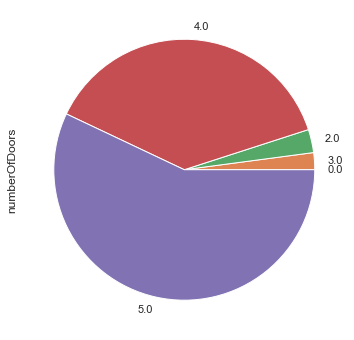

In [151]:
df.numberOfDoors.value_counts(ascending=True).plot.pie(figsize=(6, 6))

Как мы видим, на графике основная часть объявлений авто с 4 и 5 дверями, всё остальное, скорее всего попадает в выбросы, с которыми мы ничего делать не будем

Добавим признак numberOfDoors в списоки

In [152]:
cat_cols.append('numberOfDoors')
drop_cols.append('numberOfDoors')

### 18. parsing_unixtime

In [153]:
df.parsing_unixtime = pd.to_datetime(df.parsing_unixtime,unit='s').dt.date.astype('str')

In [154]:
df.parsing_unixtime.unique()

array(['2020-10-20', '2020-10-19', '2020-10-21', '2020-10-24',
       '2020-10-25', '2020-10-26', 'NaT', '2022-02-21', '2022-02-22',
       '2022-02-24', '2022-02-23'], dtype=object)

In [155]:
type(df.parsing_unixtime[0])

str

In [156]:
df.parsing_unixtime = df.parsing_unixtime.apply(lambda value: '2020-09-09' if value == 'NaT' else value)
df.parsing_unixtime.value_counts()

2020-09-09    88966
2020-10-21    15907
2022-02-21     7885
2020-10-20     6813
2020-10-19     6441
2022-02-22     6346
2022-02-23     4899
2022-02-24     3164
2020-10-25     2944
2020-10-24     2123
2020-10-26      458
Name: parsing_unixtime, dtype: int64

Привяжем курс доллара к дате парсинга, чтобы скорректировать цены в датасетах, полученных в разные года

In [157]:
df = df.apply(usd, axis=1)
df.head(2)

bodyType  brand                                            car_url  color  \
0  liftback  skoda  https://auto.ru/cars/used/sale/skoda/octavia/1...   blue   
1  liftback  skoda  https://auto.ru/cars/used/sale/skoda/octavia/1...  black   

  complectation_dict                                        description  \
0               None  Все автомобили, представленные в продаже, прох...   
1               None  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...   

   engineDisplacement  enginePower  \
0                 1.2        105.0   
1                 1.6        110.0   

                                      equipment_dict fuelType  \
0  [engine-proof, tinted-glass, airbag-driver, au...   petrol   
1  [cruise-control, asr, esp, airbag-driver, isof...   petrol   

                                               image  mileage  modelDate  \
0  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    74000       2013   
1  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    60563       2017   

                                          model_info model_name  \
0  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
1  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   

                 name  numberOfDoors parsing_unixtime priceCurrency  \
0  1.2 AMT (105 л.с.)            5.0       2020-10-20           RUB   
1   1.6 MT (110 л.с.)            5.0       2020-10-20           RUB   

  productionDate       sell_id  \
0           2014  1100575026.0   
1           2017  1100549428.0   

                                           super_gen     vehicleConfiguration  \
0  {"id":"10373605","displacement":1197,"engine_t...       LIFTBACK ROBOT 1.2   
1  {"id":"20913311","displacement":1598,"engine_t...  LIFTBACK MECHANICAL 1.6   

  vehicleTransmission    vendor    Владельцы Владение       ПТС    Привод  \
0    роботизированная  EUROPEAN  3 или более      NaN  Оригинал  передний   
1        механическая  EUROPEAN   1 владелец      NaN  Оригинал  передний   

    Руль           Состояние     Таможня  sample price start_date  hidden  \
0  Левый  Не требует ремонта  Растаможен       0   0.0        NaN     NaN   
1  Левый  Не требует ремонта  Растаможен       0   0.0        NaN     NaN   

  Стоимость          model       usd  
0       NaN  skoda_OCTAVIA  0.012833  
1       NaN  skoda_OCTAVIA  0.012833

Сохраним поправочный коэффициент отдельно

In [158]:
df_ratio = df[['usd', 'sample']]
df_ratio

usd  sample
0       0.012833       0
1       0.012833       0
2       0.012833       0
3       0.012833       0
4       0.012833       0
...          ...     ...
147820  0.012435       1
147821  0.012435       1
147822  0.012435       1
147823  0.012435       1
147824  0.012435       1

[145946 rows x 2 columns]

Отредактируем списки

In [159]:
drop_cols.append('parsing_unixtime')
drop_cols.append('usd')

### 19. priceCurrency

In [160]:
df.priceCurrency.unique()

array(['RUB', nan, 'ruble'], dtype=object)

Признак priceCurrency неинформативен для предсказания стоимости авто
Добавим признак priceCurrency в список drop_cols:

In [161]:
drop_cols.append('priceCurrency')

### 20. productionDate

Это количественный признак, сделаем предположение, что он сильно коррелирует с **modelDate**, мы на это посмотрим, когда постоим матрицу корреляции для количественных признаков

Посмотрим на пропуски

In [162]:
df.productionDate.isnull().sum()

0

In [163]:
df.productionDate.unique()

array([2014, 2017, 2012, 2011, 2019, 2018, 2010, 2020, 2016, 2013, 2006,
       2007, 2015, 2005, 2008, 2009, 1997, 2004, 2002, 1987, 2003, 2001,
       1976, 2000, 1998, 1995, 1999, 1993, 1939, 1996, 1984, 1990, 1991,
       1992, 1989, 1982, 1985, 1994, 1938, 1981, 1988, 1983, 1980, 1986,
       1978, 1970, 1979, 1977, 1972, 1975, 1969, 1950, 1953, 1949, 1937,
       1959, 1968, 1936, 1904, 1974, 1967, 1961, 1960, 1965, 1963, 1957,
       1952, 1973, 1948, 1955, 1964, 1971, 1931, 1927, 1923, 1924, 1932,
       1951, 1954, 1966, '2012', '2018', '2013', '2011', '2008', '2014',
       '2019', '2021', '2007', '2016', '2009', '2004', '2010', '2020',
       '2015', '2017', '1994', '2003', '1998', '2006', '2000', '1990',
       '2005', '1996', '2001', '1991', '1988', '1995', '1993', '1989',
       '2002', '2022', '1999', '1997', '1984', '1987', '1992', '1983',
       '1986', '1985', '1939', '1970', '1968', '1982', '1950', '1946'],
      dtype=object)

In [164]:
df.productionDate = df.productionDate.apply(production_date)

In [165]:
df.productionDate.unique()

array([2014, 2017, 2012, 2011, 2019, 2018, 2010, 2020, 2016, 2013, 2006,
       2007, 2015, 2005, 2008, 2009, 1997, 2004, 2002, 1987, 2003, 2001,
       1976, 2000, 1998, 1995, 1999, 1993, 1939, 1996, 1984, 1990, 1991,
       1992, 1989, 1982, 1985, 1994, 1938, 1981, 1988, 1983, 1980, 1986,
       1978, 1970, 1979, 1977, 1972, 1975, 1969, 1950, 1953, 1949, 1937,
       1959, 1968, 1936, 1904, 1974, 1967, 1961, 1960, 1965, 1963, 1957,
       1952, 1973, 1948, 1955, 1964, 1971, 1931, 1927, 1923, 1924, 1932,
       1951, 1954, 1966, 2021, 2022, 1946], dtype=int64)

Посмотрим распределение двух этих признаков по датасету

<AxesSubplot:title={'center':'modelDate'}, ylabel='Frequency'>

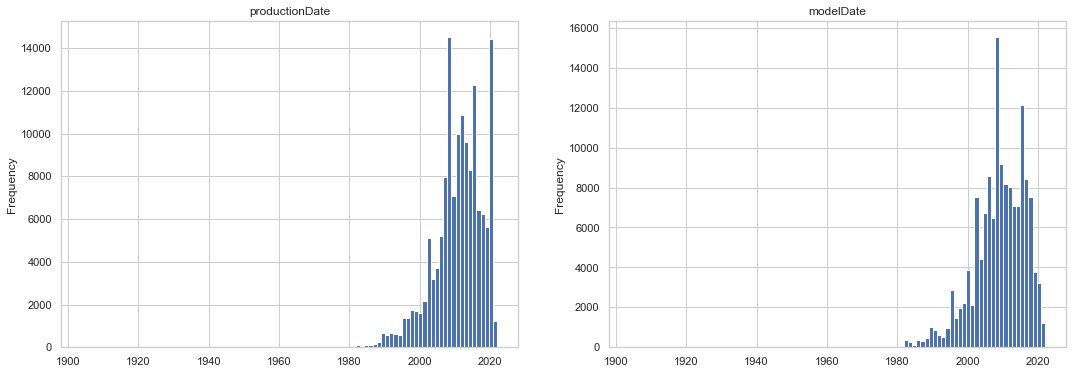

In [166]:

fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
df.productionDate.plot(kind='hist', bins=100, ax=axes[0],
                          grid=True, title='productionDate')
df.modelDate.plot(kind='hist', bins=100, ax=axes[1],
                     grid=True, title='modelDate')

Посмотрим на выбросы:

In [167]:
IQR_outlier(df, 'productionDate', verbose=True)

Для признака productionDate :
25-й перцентиль: 2007.0 75-й перцентиль: 2016.0, IQR: 9.0,  Границы выбросов: [1993.5, 2029.5].
Выбросов, согласно IQR: 3500 | 2.40%


Добавим признак productionDate в список num_cols:

In [168]:
num_cols.append('productionDate')

### 21. sell_id

Признак sell_id неинформативен для предсказания стоимости авто
Добавим признак sell_id в список drop_cols:

In [169]:
drop_cols.append('sell_id')

### 22. super_gen

In [170]:
df.super_gen[56]

'{"id":"20696893","displacement":1395,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":150,"power_kvt":110,"human_name":"1.4 AMT (150 л.с.)","acceleration":8.8,"clearance_min":164,"fuel_rate":5.8}'

In [171]:
df.super_gen.isnull().sum()

89278

Слишком много пропусков
Добавим признак super_gen в список drop_cols:

In [172]:
drop_cols.append('super_gen')

### 23.vehicleConfiguration

In [173]:
df.vehicleConfiguration[89]

'LIFTBACK AUTOMATIC 1.8'

Признак полностью дублирует такие признаки как bodyType, engineDisplacement и vehicleTransmission
Добавим признак vehicleConfiguration в список drop_cols:

In [174]:
drop_cols.append('vehicleConfiguration')

### 24.vehicleTransmission

Посмотрим какие значения принимает признак и их количество в датасете df:

In [175]:
print('Количество различых типов коробок передач в датасете:', df.vehicleTransmission.nunique())
df.vehicleTransmission.value_counts(dropna=False)

Количество различых типов коробок передач в датасете: 8


AUTOMATIC           48963
автоматическая      34572
MECHANICAL          25159
механическая         8960
роботизированная     8224
ROBOT                7838
VARIATOR             7006
вариатор             5224
Name: vehicleTransmission, dtype: int64

In [176]:
# Исправим регистр:
df.vehicleTransmission = df.vehicleTransmission.str.lower()

In [177]:
df.vehicleTransmission.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор',
       'mechanical', 'automatic', 'robot', 'variator'], dtype=object)

Сделаем этому признаку позднее one-hot encoding, но сейчас изменим значения признака на принятую аббревиатуру:

In [178]:
dict_Transmission = {'автоматическая':'AT', 'механическая':'MT', 'вариатор':'CVT', 'роботизированная':'AMT',
                     'mechanical':'MT', 'automatic':'AT', 'robot':'AMT', 'variator':'CVT'}
df.vehicleTransmission = df.vehicleTransmission.map(lambda x: dict_Transmission.get(x,x))

Добавим признак vehicleTransmission в списоки

In [179]:
cat_cols.append('vehicleTransmission')
drop_cols.append('vehicleTransmission')

### 25.vendor

Посмотрим на регионы-поставщики авто из нашего датасета:

In [180]:
df.vendor.unique()

array(['EUROPEAN', 'JAPANESE', nan, None], dtype=object)

In [181]:
df.brand.unique()

array(['skoda', 'audi', 'honda', 'volvo', 'bmw', 'nissan', 'infiniti',
       'mercedes', 'toyota', 'lexus', 'volkswagen', 'mitsubishi',
       'cadillac', 'chery', 'chevrolet', 'chrysler', 'citroen', 'daewoo',
       'dodge', 'ford', 'geely', 'hyundai', 'jaguar', 'jeep', 'kia',
       'mazda', 'mini', 'opel', 'peugeot', 'porsche', 'renault', 'subaru',
       'suzuki', 'great_wall', 'land_rover', 'ssang_yong'], dtype=object)

Добавим признак vendor в список cat_cols

In [182]:
cat_cols.append('vendor')
drop_cols.append('vendor')

### 26.Владельцы

Переименуем столбец

In [183]:
df.rename(columns = {'Владельцы':'Owners'}, inplace = True)

Изменим значения признака на понятные значения:

In [184]:
dict_Owners = {'3 или более':'3_or_more', '1\xa0владелец':'1', '2\xa0владельца':'2', 3:'3_or_more', 2:'2', 1:'1'}
df.Owners = df.Owners.fillna('unknown')
df.Owners = df.Owners.map(lambda x: dict_Owners.get(x,x))

In [185]:
df.Owners.unique()

array(['3_or_more', '1', '2', 'unknown'], dtype=object)

Добавим признак Owners в списки

In [186]:
cat_cols.append('Owners')
drop_cols.append('Owners')

### 27.Владение

In [187]:
df['Владение'][456]

'1 год и 10 месяцев'

Признак Владение имеет более 72,13% пропусков, мы его удалим.
Добавим признак Владение в список drop_cols:

In [188]:
drop_cols.append('Владение')

### 28.ПТС

Переименуем столбец

In [189]:
df.rename(columns = {'ПТС':'pts'}, inplace = True)

In [190]:
df.pts.unique()

array(['Оригинал', 'Дубликат', nan, 'ORIGINAL', 'DUPLICATE'], dtype=object)

In [191]:
df.pts.value_counts(dropna=False)

ORIGINAL     78229
Оригинал     49637
DUPLICATE    10376
Дубликат      7342
NaN            362
Name: pts, dtype: int64

In [192]:
df.pts = df.pts.str.lower()

Наличие дубликата ПТС несёт в себе риски при продаже автомобиля, и возможно, имеет какое-то влияние на цену
И тут нет зависимости от того, когда был выпущен автомобиль
В подтверждение наших доводов, посмотрим, какой ПТС у самого старого авто в датасете:

In [193]:
df[(df.productionDate == df.productionDate.min())]['pts']

16944    оригинал
Name: pts, dtype: object

Заполним пропуски (у признака только один пропуск):

In [194]:
df.pts = df.pts.fillna(df.pts.mode()[0])

Добавим признак ПТС в списки

In [195]:
cat_cols.append('pts')
drop_cols.append('pts')

### 29.Привод

In [196]:
df['Привод'].isnull().sum()

0

In [197]:
df['Привод'].unique()

array(['передний', 'полный', 'задний'], dtype=object)

Переименуем столбец

In [198]:
df.rename(columns={'Привод': 'drive'}, inplace=True)

Изменим значения признака на принятую аббревиатуру:

In [199]:
dict_drive = {'передний': 'front_wheel', 'полный': 'four_wheel', 'задний': 'rear'}
df.drive = df.drive.map(lambda x: dict_drive.get(x, x))

Добавим признак Drive в списки

In [200]:
cat_cols.append('drive')
drop_cols.append('drive')

### 30.Руль

In [201]:
df['Руль'].isnull().sum()

0

In [202]:
df['Руль'].unique()

array(['Левый', 'Правый', 'LEFT', 'RIGHT'], dtype=object)

In [203]:
df['Руль'] = df['Руль'].str.lower()

Переименуем столбец

In [204]:
df.rename(columns={'Руль': 'hand'}, inplace=True)

Изменим значения признака на принятую аббревиатуру:

In [205]:
dict_rudder = {'левый': 'left', 'правый': 'right'}
df.hand = df.hand.map(lambda x: dict_rudder.get(x, x))

In [206]:
df.hand.unique()

array(['left', 'right'], dtype=object)

Добавим признак hand в списки

In [207]:
cat_cols.append('hand')
drop_cols.append('hand')

### 31.Состояние

In [208]:
df['Состояние'].isnull().sum()

88988

In [209]:
df['Состояние'].unique()

array(['Не требует ремонта', nan, None], dtype=object)

Признак имеет одно значение для всей выборки и 88988 пропусков, поэтому удаляем его
Добавим признак Состояние в список drop_cols:

In [210]:
drop_cols.append('Состояние')

### 32.Таможня

In [211]:
df['Таможня'].isnull().sum()

42

In [212]:
df['Таможня'].unique()

array(['Растаможен', True, None], dtype=object)

Признак имеет одно значение для всей выборки, поэтому удаляем его
Добавим признак Таможня в список drop_cols:

In [213]:
drop_cols.append('Таможня')

### 33. start_date

In [214]:
df['start_date'].isnull().sum()

56980

Признак имеет 56980 пропусков, поэтому удаляем его
Добавим признак start_date в список drop_cols:

In [215]:
drop_cols.append('start_date')

### 34. hidden

In [216]:
df['hidden'].isnull().sum()

145946

Признак имеет 145946 пропусков, поэтому удаляем его
Добавим признак start_date в список drop_cols:

In [217]:
drop_cols.append('hidden')

### 35. Стоимость

Дублирует price
Добавим признак Стоимость в список drop_cols:

In [218]:
drop_cols.append('Стоимость')

## Количественные признаки

Посмотрим распределение числовых параметров

<Figure size 864x432 with 0 Axes>

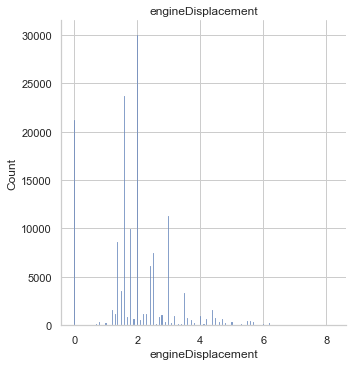

<Figure size 864x432 with 0 Axes>

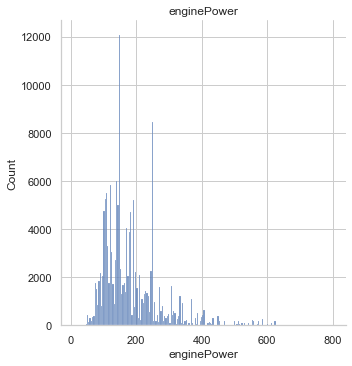

<Figure size 864x432 with 0 Axes>

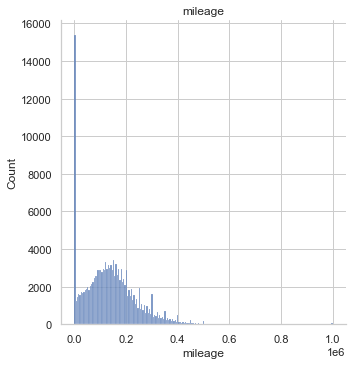

<Figure size 864x432 with 0 Axes>

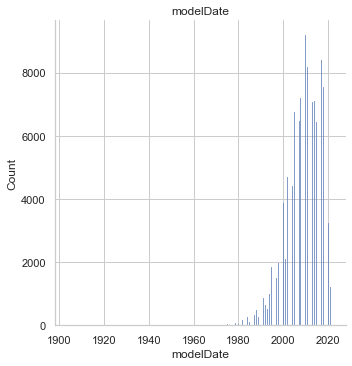

<Figure size 864x432 with 0 Axes>

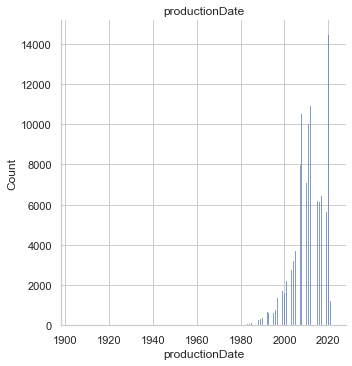

In [219]:
for col in num_cols:
    plt.figure()
    sns.displot(df[col], kde = False, rug=False)
    plt.title(col)
    plt.show()

Перед логорифмированием внесем поправку в price

In [220]:
df.price = df.price.astype(float) * df_ratio.usd

логарифмируем числовые переменные, чтобы сгладить разницу в размерности и уменьшить выбросы

In [221]:
num_cols.append('price')
for col in num_cols:
    df[col] =  np.log(df[col] + 1)

Посмотрим сколько выбросов осталось в числовых признаках после логарифмирования:

In [222]:
for col in num_cols:
    IQR_outlier(df, col, verbose=True)
    print()
num_cols.remove('price')

Для признака engineDisplacement :
25-й перцентиль: 0.9162907318741551 75-й перцентиль: 1.2237754316221157, IQR: 0.30748469974796055,  Границы выбросов: [0.4550636822522143, 1.6850024812440565].
Выбросов, согласно IQR: 26899 | 18.43%

Для признака enginePower :
25-й перцентиль: 4.812184355372417 75-й перцентиль: 5.41610040220442, IQR: 0.6039160468320031,  Границы выбросов: [3.9063102851244125, 6.321974472452425].
Выбросов, согласно IQR: 1181 | 0.81%

Для признака mileage :
25-й перцентиль: 11.097425172408931 75-й перцентиль: 12.190964083849375, IQR: 1.0935389114404437,  Границы выбросов: [9.457116805248265, 13.83127245101004].
Выбросов, согласно IQR: 17429 | 11.94%

Для признака modelDate :
25-й перцентиль: 7.603897968521881 75-й перцентиль: 7.608374474380783, IQR: 0.0044765058589018025,  Границы выбросов: [7.597183209733529, 7.615089233169136].
Выбросов, согласно IQR: 4153 | 2.85%

Для признака productionDate :
25-й перцентиль: 7.60489448081162 75-й перцентиль: 7.6093665379542115, IQR:

посмотрим на корреляцию между собой числовых переменных

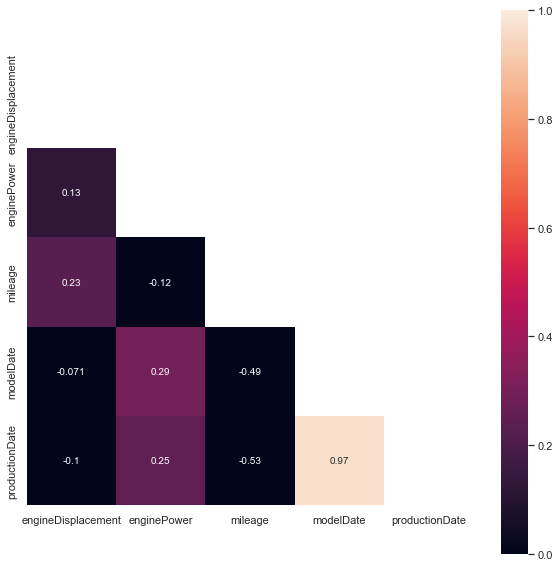

In [223]:
heatmap(df, num_cols, 'pearson')

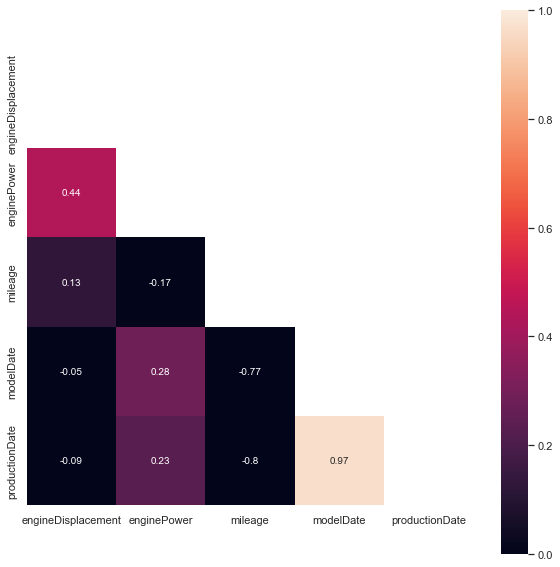

In [224]:
heatmap(df, num_cols, 'spearman')

Отредактируем списки

In [225]:
num_cols.remove('modelDate')
drop_cols.append('modelDate')

## Kатегориальные переменные

Для категориальных признаков мы будем использовать OneHotEncoder

In [226]:
encoder = OneHotEncoder(sparse = False)
X_cat = encoder.fit_transform(df[cat_cols].values)

In [227]:
list_of_cols = encoder.get_feature_names(cat_cols).tolist()
X_cat_column = pd.DataFrame(X_cat, columns = list_of_cols)
df = pd.concat([df,X_cat_column],axis = 1)

Удалим признаки из списка drop_cols из нашего датасета:

In [228]:
df.drop(drop_cols, axis = 1, inplace=True)

In [229]:
df.head()

engineDisplacement  enginePower    mileage  productionDate  sample  price  \
0            0.788457     4.663439  11.211834        7.608374     0.0    0.0   
1            0.955511     4.709530  11.011456        7.609862     0.0    0.0   
2            1.029619     5.030438  11.385103        7.608374     0.0    0.0   
3            0.955511     4.709530  11.461643        7.608374     0.0    0.0   
4            1.029619     5.030438  10.977414        7.607381     0.0    0.0   

   bodyType_SUV_5  bodyType_hatchback  bodyType_liftback  bodyType_rare  \
0             0.0                 0.0                1.0            0.0   
1             0.0                 0.0                1.0            0.0   
2             0.0                 0.0                1.0            0.0   
3             0.0                 0.0                1.0            0.0   
4             0.0                 0.0                1.0            0.0   

   bodyType_sedan  bodyType_station_wagon  color_black  color_blue  \
0             0.0                     0.0          0.0         1.0   
1             0.0                     0.0          1.0         0.0   
2             0.0                     0.0          0.0         0.0   
3             0.0                     0.0          0.0         0.0   
4             0.0                     0.0          0.0         0.0   

   color_gray  color_rare  color_red  color_white  fuelType_diesel  \
0         0.0         0.0        0.0          0.0              0.0   
1         0.0         0.0        0.0          0.0              0.0   
2         1.0         0.0        0.0          0.0              0.0   
3         0.0         1.0        0.0          0.0              0.0   
4         0.0         0.0        0.0          1.0              0.0   

   fuelType_electro  fuelType_gas  fuelType_gbo  fuelType_hybrid  \
0               0.0           0.0           0.0              0.0   
1               0.0           0.0           0.0              0.0   
2               0.0           0.0           0.0              0.0   
3               0.0           0.0           0.0              0.0   
4               0.0           0.0           0.0              0.0   

   fuelType_petrol  model_audi_A6  model_audi_Audi  model_audi_rare  \
0              1.0            0.0              0.0              0.0   
1              1.0            0.0              0.0              0.0   
2              1.0            0.0              0.0              0.0   
3              1.0            0.0              0.0              0.0   
4              1.0            0.0              0.0              0.0   

   model_bmw_3ER  model_bmw_5ER  model_bmw_BMW  model_bmw_X5  model_bmw_rare  \
0            0.0            0.0            0.0           0.0             0.0   
1            0.0            0.0            0.0           0.0             0.0   
2            0.0            0.0            0.0           0.0             0.0   
3            0.0            0.0            0.0           0.0             0.0   
4            0.0            0.0            0.0           0.0             0.0   

   model_cadillac_rare  model_chery_rare  model_chevrolet_rare  \
0                  0.0               0.0                   0.0   
1                  0.0               0.0                   0.0   
2                  0.0               0.0                   0.0   
3                  0.0               0.0                   0.0   
4                  0.0               0.0                   0.0   

   model_chrysler_rare  model_citroen_rare  model_daewoo_rare  \
0                  0.0                 0.0                0.0   
1                  0.0                 0.0                0.0   
2                  0.0                 0.0                0.0   
3                  0.0                 0.0                0.0   
4                  0.0                 0.0                0.0   

   model_dodge_rare  model_ford_FOCUS  model_ford_rare  model_geely_rare  \
0               0.0               0.0           

In [230]:
df.isnull().sum()

engineDisplacement    1792
enginePower           1792
mileage               1792
productionDate        1792
sample                1792
                      ... 
drive_four_wheel      1792
drive_front_wheel     1792
drive_rear            1792
hand_left             1792
hand_right            1792
Length: 108, dtype: int64

In [231]:
df.tail(1793)

engineDisplacement  enginePower    mileage  productionDate  sample  \
145945            1.098612     5.505332  11.801265        7.608374     1.0   
145946            1.098612     5.017280  10.633184        7.611348     1.0   
145947            1.252763     5.141664  12.899222        7.599902     1.0   
145948            1.098612     5.220356  11.951187        7.608374     1.0   
145949            1.335001     5.267858  12.611541        7.599902     1.0   
...                    ...          ...        ...             ...     ...   
147820            1.386294     5.521461  12.196027        7.607381     1.0   
147821            1.098612     5.220356  11.018154        7.610358     1.0   
147822            1.386294     5.389072  12.043560        7.609367     1.0   
147823            1.335001     5.267858  12.706851        7.599902     1.0   
147824            0.955511     4.919981  11.760730        7.607878     1.0   

            price  bodyType_SUV_5  bodyType_hatchback  bodyType_liftback  \
145945  10.145646             0.0                 0.0                0.0   
145946  10.480852             NaN                 NaN                NaN   
145947   8.155577             NaN                 NaN                NaN   
145948  10.085817             NaN                 NaN                NaN   
145949   8.406827             NaN                 NaN                NaN   
...           ...             ...                 ...                ...   
147820  10.016086             NaN                 NaN                NaN   
147821  10.584218             NaN                 NaN                NaN   
147822  10.526894             NaN                 NaN                NaN   
147823   8.289072             NaN                 NaN                NaN   
147824   9.799184             NaN                 NaN                NaN   

        bodyType_rare  bodyType_sedan  bodyType_station_wagon  color_black  \
145945            0.0             1.0                     0.0          0.0   
145946            NaN             NaN                     NaN          NaN   
145947            NaN             NaN                     NaN          NaN   
145948            NaN             NaN                     NaN          NaN   
145949            NaN             NaN                     NaN          NaN   
...               ...             ...                     ...          ...   
147820            NaN             NaN                     NaN          NaN   
147821            NaN             NaN                     NaN          NaN   
147822            NaN             NaN                     NaN          NaN   
147823            NaN             NaN                     NaN          NaN   
147824            NaN             NaN                     NaN          NaN   

        color_blue  color_gray  color_rare  color_red  color_white  \
145945         0.0         0.0         0.0        1.0          0.0   
145946         NaN         NaN         NaN        NaN          NaN   
145947         NaN         NaN         NaN        NaN          NaN   
145948         NaN         NaN         NaN        NaN          NaN   
145949         NaN         NaN         NaN        NaN          NaN   
...            ...         ...         ...        ...          ...   
147820         NaN         NaN         NaN        NaN          NaN   
147821         NaN         NaN         NaN        NaN          NaN   
147822         NaN         NaN         NaN        NaN          NaN   
147823         NaN         NaN         NaN        NaN          NaN   
147824         NaN         NaN         NaN        NaN          NaN   

        fuelType_diesel  fuelType_electro  fuelType_gas  fuelType_gbo  \
145945              0.0               0.0           0.0           0.0   
145946              NaN               NaN           NaN           NaN   
145947              NaN               NaN           NaN           NaN   
145948              NaN               NaN           NaN           NaN   
145949         

так как последние 1792 значения выдают NaN при encoder, и побороть данную проблему не получается, просто удалим их.

In [232]:
df = df.dropna(subset=['bodyType_SUV_5'])

In [233]:
df.isnull().sum()

engineDisplacement    1792
enginePower           1792
mileage               1792
productionDate        1792
sample                1792
                      ... 
drive_four_wheel         0
drive_front_wheel        0
drive_rear               0
hand_left                0
hand_right               0
Length: 108, dtype: int64

Проверяем, что размер df_test не изменился:

In [234]:
df[(df['sample'] == 0)].shape

(34686, 108)

In [235]:
df = df.dropna()
df.shape

(144154, 108)

In [236]:
df.isnull().sum()

engineDisplacement    0
enginePower           0
mileage               0
productionDate        0
sample                0
                     ..
drive_four_wheel      0
drive_front_wheel     0
drive_rear            0
hand_left             0
hand_right            0
Length: 108, dtype: int64

**Разделяем датасет data обратно на df_train и df_test**

In [237]:
df_train = df.query('sample == 1').drop(['sample'], axis=1)
display(df_train.shape)
df_test = df.query('sample == 0').drop(['sample', 'price'], axis=1)
display(df_test.shape)

(109468, 107)

(34686, 106)

Нормализация численных данных
Для тестовой выборки

In [238]:
# scaler_test = RobustScaler()
# for column in num_cols:
    # df_test[column] = scaler_test.fit_transform(np.array(df_test[column].values).reshape(-1, 1))
    # df_train[column] = scaler_test.fit_transform(np.array(df_train[column].values).reshape(-1, 1))

# Model

In [239]:
X = df_train.loc[:, df_train.columns != 'price']
y = df_train['price'].values

In [240]:
X.shape, df_test.shape

((109468, 106), (34686, 106))

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [242]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((93047, 106), (16421, 106), (93047,), (16421,))

In [243]:
y_test = y_test.astype(float)

In [244]:
y_test

array([9.62071541, 9.19766364, 8.4498209 , ..., 8.28152481, 8.61792472,
       8.66443651])

## LinearRegression

In [245]:
model1 = LinearRegression()
model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)
display(y_pred.shape)
print(f"Точность наивной модели по метрике MAPE: {mean_absolute_percentage_error(y_test, y_pred) * 100}%")

(16421,)

Точность наивной модели по метрике MAPE: 2.868796606808845%


## RandomForestRegressor

In [246]:
#param = {'n_estimators': [400],
#'max_features': ['auto'],
##'max_depth': [None, 10, 20, 30, 40],
#'min_samples_split': [1, 2, 5, 10, 20],
#'min_samples_leaf': [1, 2, 4, 8, 12]}

In [247]:
#rf = RandomForestRegressor(random_state=42)
#rcv = RandomizedSearchCV(estimator=rf, param_distributions=param, cv=3, n_jobs=-1,
                          #scoring='neg_mean_absolute_percentage_error', n_iter=20)

#rcv.fit(X_train, y_train)
#predict = rcv.predict(X_test)
#predict = np.exp(predict)
#MAPE = mean_absolute_percentage_error(y_test, predict) * 100
#MAPE 

In [248]:
#rcv.best_params_

In [249]:
rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Точность модели по метрике MAPE: {mean_absolute_percentage_error(y_test, y_pred) * 100}%")

Точность модели по метрике MAPE: 1.6409099600955397%


## XGBRegressor

In [250]:
# param = {'n_estimators': [1000],
#          'colsample_bytree': [0.5, 0.75, 1.0],
#          'min_child_weight': [1, 3, 5],
#          'eta': [0.2],
#          'max_depth': [3, 6, 8],
#          'subsample': [0.5, 1.0]}

In [251]:
# xgb = XGBRegressor(n_estimators=500, eval_metric='mape',random_state=42)
# rcv = RandomizedSearchCV(estimator=xgb, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=15)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

In [252]:
# rcv.best_params_

In [253]:
xgb = XGBRegressor()

xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

print(f"Точность модели XGBoost по метрике MAPE: {mean_absolute_percentage_error(y_test, y_pred) * 100}%")

Точность модели XGBoost по метрике MAPE: 1.7913136885248913%


## ExtraTreesRegressor

In [254]:
# param = {'n_estimators': [200],
#          'max_features': ['auto'],
#          'max_depth': [None, 10, 20, 30, 40],
#          'min_samples_split': [1, 2, 5, 10, 20],
#          'min_samples_leaf': [1, 2, 4, 8, 12],
#          'bootstrap': [True, False]}

In [255]:
#etr = ExtraTreesRegressor(n_estimators=800, random_state=42, n_jobs=-1,
                          #bootstrap=False, min_samples_split=10, min_samples_leaf=1,
                          #max_features='auto', max_depth=20)
#etr.fit(X_train, y_train)
#predict = etr.predict(X_test)
#predict = np.exp(predict)
#MAPE = mean_absolute_percentage_error(y_test, predict) * 100
#MAPE

In [256]:
# rcv.best_params_

In [257]:
etr = ExtraTreesRegressor(random_state=RANDOM_SEED)
etr.fit(X_train,y_train)
y_pred = etr.predict(X_test)
print(f"Точность модели по метрике MAPE: {mean_absolute_percentage_error(y_test, y_pred) * 100}%")

Точность модели по метрике MAPE: 1.6899741064659024%


## LGBMRegressor

In [258]:
# param = {'n_estimators': [2500],
#          'learning_rate': [0.1],
#          'max_depth': [-1, 2, 4, 6],
#          'num_leaves': [20, 30 , 40, 50],
#          'min_child_samples': [None, 5, 10, 20],
#          'lambda_l2': [0.05, 0.1, 0.3, 0.8, 1.5]}

In [259]:
# lgbm = LGBMRegressor(objective='regression', random_state=30)
# rcv = RandomizedSearchCV(estimator=lgbm, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=15)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

In [260]:
# rcv.best_params_

In [261]:
#lgbm = LGBMRegressor(objective='mape', 
                   #  random_state=30,
                   #  n_estimators=2500,
                   #  learning_rate=0.05,
                   #  lambda_l2=0.5)

#lgbm.fit(X_train, y_train,
      #   eval_set=(X_test, np.log(y_test)))

In [262]:
#predict = lgbm.predict(X_test)
#predict = np.exp(predict)
#MAPE = mean_absolute_percentage_error(y_test, predict) * 100
#MAPE

Модель с параметрами по умолчанию

In [263]:
lgbm = LGBMRegressor(random_state=RANDOM_SEED)
lgbm.fit(X_train,y_train)
y_pred = lgbm.predict(X_test)
print(f"Точность модели по метрике MAPE: {mean_absolute_percentage_error(y_test, y_pred) * 100}%")

Точность модели по метрике MAPE: 1.9751581234177584%


## CATboost

In [264]:
#params = {'iterations': [5000],
         # 'depth': [None, 4, 5, 6, 7],
         # 'l2_leaf_reg': [0.1, 0.4, 1, 3, 5],
         # 'random_strength': [0, 0.3, 0.7, 1]}

In [265]:
#cbr = CatBoostRegressor(random_seed=20, loss_function='MAPE',
                      #  eval_metric='MAPE', verbose=0)
#rs_cbr = cbr.randomized_search(params, X, y, cv=3, n_iter=20)
#rs_cbr['params']

In [266]:
cbr = CatBoostRegressor(iterations=5000,
                        random_seed=30,
                        loss_function='MAPE',
                        learning_rate=0.06,
                        depth=7,
                        random_strength=0.3,
                        l2_leaf_reg=0.15)

cbr.fit(X_train, y_train,
        eval_set=(X_test,y_test),
        verbose_eval=0,
        use_best_model=True)

In [267]:
y_predict = cbr.predict(X_test)

print(f"Точность модели по метрике MAPE: {mean_absolute_percentage_error(y_test, y_pred) * 100}%")

Точность модели по метрике MAPE: 1.9751581234177584%


## StackingRegressor

In [268]:
estimators = [('cbr', cbr), ('xgb', xgb), ('etr', etr), ('lgbm', lgbm)]
stacking = StackingRegressor(estimators=estimators,
                             final_estimator=Ridge())
stacking.fit(X_train, y_train)

0:	learn: 0.0897211	total: 22.2ms	remaining: 1m 50s
1:	learn: 0.0856075	total: 43.9ms	remaining: 1m 49s
2:	learn: 0.0817059	total: 63.4ms	remaining: 1m 45s
3:	learn: 0.0780814	total: 84ms	remaining: 1m 44s
4:	learn: 0.0746528	total: 105ms	remaining: 1m 44s
5:	learn: 0.0714083	total: 126ms	remaining: 1m 45s
6:	learn: 0.0683928	total: 144ms	remaining: 1m 42s
7:	learn: 0.0656215	total: 163ms	remaining: 1m 41s
8:	learn: 0.0630070	total: 181ms	remaining: 1m 40s
9:	learn: 0.0604133	total: 202ms	remaining: 1m 40s
10:	learn: 0.0580818	total: 220ms	remaining: 1m 39s
11:	learn: 0.0557462	total: 241ms	remaining: 1m 40s
12:	learn: 0.0536419	total: 259ms	remaining: 1m 39s
13:	learn: 0.0516317	total: 279ms	remaining: 1m 39s
14:	learn: 0.0498793	total: 310ms	remaining: 1m 43s
15:	learn: 0.0481628	total: 329ms	remaining: 1m 42s
16:	learn: 0.0466240	total: 349ms	remaining: 1m 42s
17:	learn: 0.0451374	total: 365ms	remaining: 1m 41s
18:	learn: 0.0437528	total: 386ms	remaining: 1m 41s
19:	learn: 0.0425221

StackingRegressor(estimators=[('cbr',
                               <catboost.core.CatBoostRegressor object at 0x000002382C3D39D0>),
                              ('xgb',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_dept...
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                    

In [269]:
y_predict = stacking.predict(X_test)
print(f"Точность модели по метрике MAPE: {mean_absolute_percentage_error(y_test, y_pred) * 100}%")

Точность модели по метрике MAPE: 1.9751581234177584%


In [270]:
final_model = stacking

In [271]:
#Записываем значения для сабмишена
y_valid = np.exp(final_model.predict(df_test))

In [272]:
predict_submission = y_valid / df_ratio.query('sample == 0')['usd']

In [273]:
sample_submission = pd.read_csv('sample_submission.csv')

In [274]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_7.csv', index=False)
sample_submission.head(10)

sell_id         price
0  1100575026  9.882219e+05
1  1100549428  1.342907e+06
2  1100658222  1.169100e+06
3  1100937408  1.034460e+06
4  1101037972  1.008448e+06
5  1100912634  1.245626e+06
6  1101228730  8.940387e+05
7  1100165896  6.642968e+05
8  1100768262  2.304461e+06
9  1101218501  1.175311e+06

# Выводы

В данных моделях мы получили переобучение.

  XGBoost и LightGBM очень мощные библиотеки для построения моделей градиентного бустинга на решающих деревьях.     Преимущества Light GBM:быстрая скорость обучения и высокая эффективность.
  Алгоритм XGBoost обладает высокой предсказательной способностью и в разы быстрее любых других методов градиентного бустинга, включает в себя различные регуляризации, что уменьшает переобучение и улучшает общую производительность.RandomForestRegressor имеет следующие преимущества:имеет высокую точность предсказания, которая сравнима с результатами градиентного бустинга; не требует тщательной настройки параметров, хорошо работает из коробки; редко переобучается. На практике добавление деревьев только улучшает композицию; хорошо работает с пропущенными данными – сохраняет хорошую точность даже при их наличии.    В Catboost прогнозы делаются на основе ансамбля слабых обучающих алгоритмов. В отличие от случайного леса, который создает дерево решений для каждой выборки, в градиентном бустинге деревья создаются последовательно. Предыдущие деревья в модели не изменяются. Результаты предыдущего дерева используются для улучшения последующего.
  В мире машинного обучения одними из самых популярных типов моделей являются решающее дерево и ансамбли на их основе. Преимуществами деревьев являются: простота интерпретации, нет ограничений на вид исходной зависимости, мягкие требования к размеру выборки. Деревья имеют и крупный недостаток — склонность к переобучению. Поэтому почти всегда деревья объединяют в ансамбли: случайный лес, градиентный бустинг и др. Сложными теоретическими и практическим задачами являются составление деревьев и объединение их в ансамбли.Extra Trees — это метод ансамблевого обучения, который объединяет результаты нескольких не коррелированных деревьев решений, собранных в «лесу», для вывода результатов.Лучшим из рассмотренных себя проявил staking моделей Catboost, XGBoost,Extra Trees и LightGBM с мета моделью линейной регрессии. В процессе работы оказалось справедливом следующее предположение : поскольку в staking мета-модель обучается на ответах уже натренированных алгоритмов, то они сильно коррелируют. Для борьбы с этим часто базовые алгоритмы не сильно оптимизируют как и было сделано в нашем случае  